# Spatio Temporal Logistic
This notebook is the first test of a spatio temporal logistic to link properly the **built-up surface** of a given region depending on its quality of life (**GDP/cap**) and of its **population density**.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from Region import Region
import pandas as pd
import geopandas as gpd

from concurrent.futures import ThreadPoolExecutor
from termcolor import colored


In [2]:
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr


def RMSE(obs, pred):
    # root mean squared error
    return np.sqrt(mean_squared_error(obs, pred))

def MAPE(obs, pred):
    # Mean absolute percentage error
    return np.mean(np.abs((obs - pred) / obs)) * 100

def STDR(obs, pred):
    # Standard deviation of residuals
    residuals = obs - pred
    return np.std(residuals)

def BIAS(obs, pred):
    # Standard bias
    residuals = obs - pred
    return np.mean(residuals)

def PEARSON(obs, pred):
    r, p = pearsonr(obs, pred)
    return r, p

def R_SQ(y_obs, y_pred):
    # Calculate residual sum of squares (SS_res)
    ss_res = np.sum((y_obs - y_pred) ** 2)

    # Calculate total sum of squares (SS_tot)
    ss_tot = np.sum((y_obs - np.mean(y_obs)) ** 2)

    # Calculate R-squared
    return 1 - (ss_res / ss_tot)

In [3]:
def concordance_correlation_coefficient(y_true, y_pred):
    mean_true = np.mean(y_true)
    mean_pred = np.mean(y_pred)
    var_true = np.var(y_true)
    var_pred = np.var(y_pred)
    cov = np.cov(y_true, y_pred)[0, 1]
    return (2 * cov) / (var_true + var_pred + (mean_true - mean_pred)**2)

## PART 1 : Theory
First we define some classical functions that will be used later for our modelisation.

### The logistic function
$f(t) = \frac{S}{1+e^{(-k(t-t_0))}}$

with: 
- *S* : the saturation level
- *k* : the slope
- $t_0$ : the half height value (left right alignement).

The logistic function serves as a predictive equation and as the motor of our dynamical models. Indeed, we observe that at the country scale, as time passes, the GDP/cap increases and some observables as the number of cars or as the number of m2/cap. This means that the quality of life, and thus the stocks consumed by a region improve. But this exponential growth does not increase indefinetely. A saturation is observed even if the GDP/cap still increase. This is explained because people usually do not own 2 or 3 cars even though they possess the money to. An logistic function, also known as the S curve, is a way to model this observation.

### The exponential decay function
$f(x) = a\, e^{-b\,x}$

with:
- *a* : the slope
- *b* : the half-life
- *c* : the bias.

The exponential decay is a decreasing exponential observed in nature (for example for the probability of nuclear decay over time). This is one of our assumption to model the decreasing phenomena observed betwenn the **built-up surface/cap** and the **population density** of a region.

In [4]:
def logistic(x, a, b, c):
    return a / (1 + np.exp(-b*(x-c)))

def exponential_decay_bias(X, a, b, c):
    return a * np.exp(-b * X) + c

def exponential_decay(X, a, b):
    return a * np.exp(-b * X) 

### The Spatio Temporal Logistic function
$f(t,x) = \frac{a\,e^{-b\,x}+c}{1 + e^{(-k(t-t_0))}}$

The Spatio Temporal Logistic function (**STL**) is the mix between our classical logistic expression and the exponential decay as S (the saturation level).

In [5]:
def STL(X, a, b, c, d):
    # STL stands for Spatio Temporal Logistic. It is an refinment of a logistic, dependant on time (here the grp_pc_usd_2015 serves 
    # as proxy for time), with a saturation level which is a function of space (here the population density of a region)
    x1, x2 = X
    saturation = exponential_decay(x2, a, b)
    return saturation / (1 + np.exp(-c*(x1-d)))

## PART 2 : Initialisation
Initialisation of the analysis parameters.

- **region_names** : (*string*) the country to study, named by their ISO3 
- **years** : (*string*) years to study
- **raster_S** : (*string*) letter used in the **GHSL** dataset (S, S_NRES, POP, ...)
- **lvl** : (*int*) the level of our administrative data (GDP and population)
- **subregion_borders** : (*string*) the path to administrative border shapefile to cut the subregions 
- **i dentifier** : (*string*) the column name to match the region names between the administrative data and the GIS data

To each region is associated a **DataFrame** (*oecd_DF_merged*) with the subregions matching administrative observables (GDP, population, etc).

In [6]:
lvl = 1

# GHSL type
raster_str = "Built_S"

In [7]:
max_workers = 16

In [8]:
data_folder = "/data/mineralogie/hautervo/data/"
folder_GHSL_S = data_folder + "Outputs/GHSL/Built_S/GADM_" + str(lvl) + "/"
folder_GHSL_POP = data_folder + "Outputs/GHSL/POP/GADM_" + str(lvl) + "/"
folder_DOSE = data_folder + "Outputs/DOSE/GADM_" + str(lvl) + "/"
folder_OSM_building = data_folder + "Outputs/OSM/building/GADM_" + str(lvl) + "/"

In [9]:
# The OECD admin units

# oecd_admin_units = data_folder + "OECD/admin_units/TL" + str(lvl) + "/OECD_TL" + str(lvl) + "_2020_ESRI54009.shp"
# gpd_oecd_admin_units = gpd.read_file(oecd_admin_units)

gadm_admin_units = data_folder + "GADM/ESRI_54009/GADM_" + str(lvl) + "_ESRI54009.shp"
gpd_gadm_admin_units = gpd.read_file(gadm_admin_units, ignore_geometry=True)

In [10]:

subregion_col = "GID_"+str(lvl)
parent_col = "GID_" + str(lvl-1) 

In [11]:
# Countries to ignore from our study (not enough data)
# country_to_pop = ["SRB", "CRI", "ISR", "CYP", "ISL", "ALB", "LIE","MNE","MKD"]
country_to_pop = ["ATA"]

In [12]:
regions_names = list(gpd_gadm_admin_units["GID_0"].unique())

# #exclude some countries if necessary
for c in country_to_pop:
    try:
        regions_names.pop(regions_names.index(c))
    except:
        pass

# regions_names = ["FRA", "DEU", "GBR", "BEL", "ITA", "LUX", "ESP", "USA", "JPN", "CAN", "AUS"] # to remove
regions_names = ["FRA", "DEU", "GBR", "BEL", "ITA", "LUX", "ESP", "CAN", "AUS", "JPN", "CHN"] # to remove
regions_names = ["FRA", "DEU", "GBR", "BEL", "ITA", "ESP", "CAN", "AUS", "JPN", "CHN"] # to remove
regions_names = ["FRA", "DEU", "GBR", "BEL", "ITA", "ESP", "USA", "CAN", "AUS", "JPN", "CHN", "IND", "IDN"] # to remove

# regions_names = ["FRA", "DEU", "GBR", "BEL", "ITA", "LUX", "ESP"] # to remove
# regions_names = ["FRA", "CHN"]

years = ["1975", "1990", "2000", "2010", "2020"] 
# years = ["2000", "2010", "2020"]
# years = ["2020"]

regions = []

for name in regions_names:
    new_region = Region(name, lvl-1)
    # new_region.parent_name = name
    # new_region.subregions.append(new_region)
    regions.append(new_region)


In [13]:
regions = []

for name in regions_names:
    new_region = Region(name, lvl-1)
    regions.append(new_region)

In [14]:
def preprocess(region):
    region.make_subregions_visual(gpd_gadm_admin_units, subregion_col, parent_col, [folder_GHSL_S, folder_GHSL_POP, folder_DOSE], years)

In [15]:
with ThreadPoolExecutor(max_workers=max_workers) as executor:
        executor.map(preprocess, regions)

[Errno 2] No such file or directory: '/data/mineralogie/hautervo/data/Outputs/GHSL/Built_S/GADM_1/AUS/AUS.1_1/1975_1990_2000_2010_2020.csv'


## PART 3 : First analysis and plots
Here we can, if we want or need to, filter some subregions from our study. 

Thus, we can plot our observables.

In [16]:
from matplotlib.font_manager import FontProperties
fontP = FontProperties()
fontP.set_size('xx-small')

colors_reg = [
    "black", "red", "peru", "darkorange", "gold", "purple", "magenta", "chartreuse", "turquoise", "darkcyan", "deepskyblue", 
    "blue", "orange", "green", "brown",
    # Additional colors
    "crimson", "lime", "orchid", "coral", "navy", "teal", "darkred", 
    "salmon", "plum", "seagreen", "midnightblue", "lightseagreen", 
    "dodgerblue", "sienna", "hotpink", "darkviolet", "lightcoral", 
    "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b",
    "#e377c2", "#7f7f7f", "#bcbd22", "#17becf", "#a6cee3", "#1f78b4", 
    "#b2df8a", "#33a02c", "#fb9a99", "#e31a1c", "#fdbf6f", "#ff7f00", 
    "#cab2d6", "#6a3d9a", "#ffff99", "#b15928", "#6b6ecf", "#9c9ede", 
    "#31a354", "#74c476", "#a1d99b", "#d9d9d9", "#636363", "#969696"
]

### PLOT 1.1 : Observable per capita compared to time

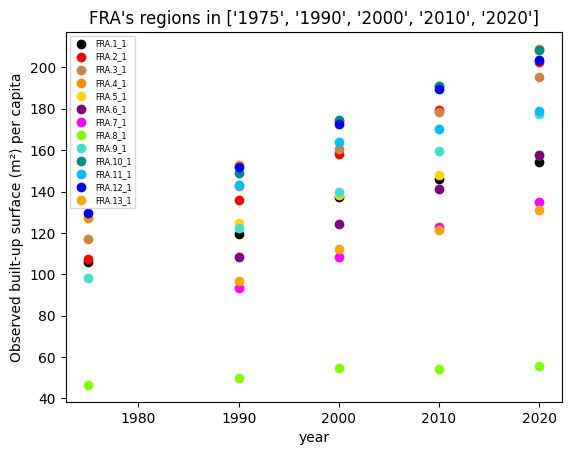

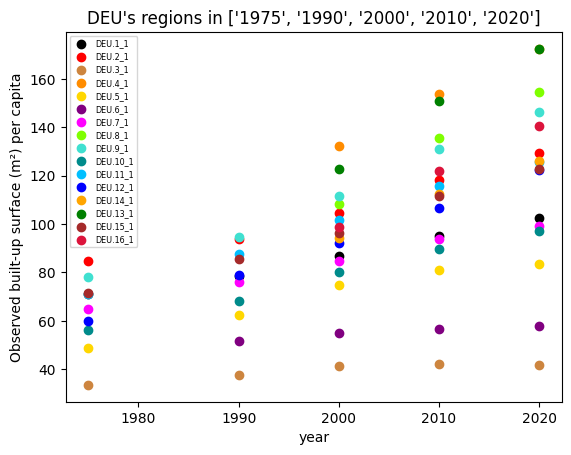

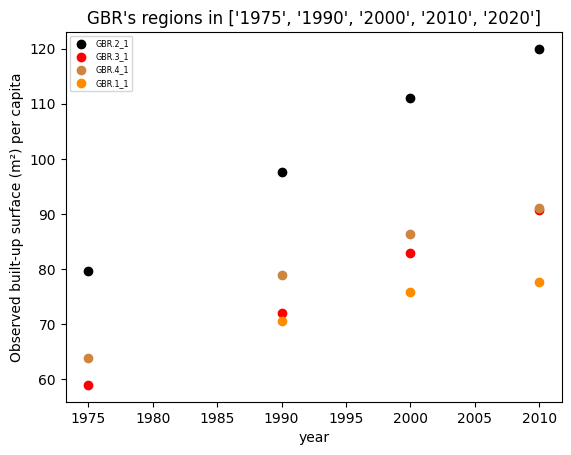

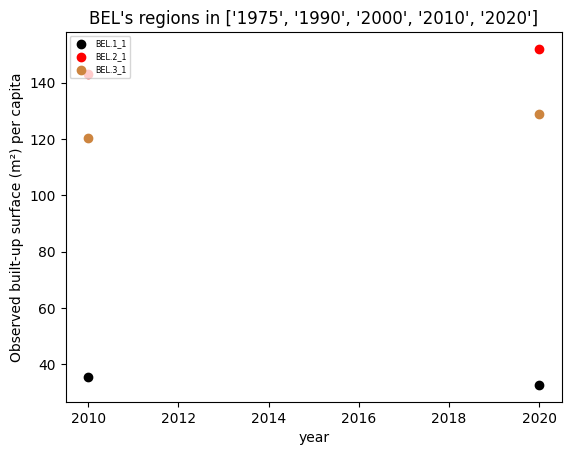

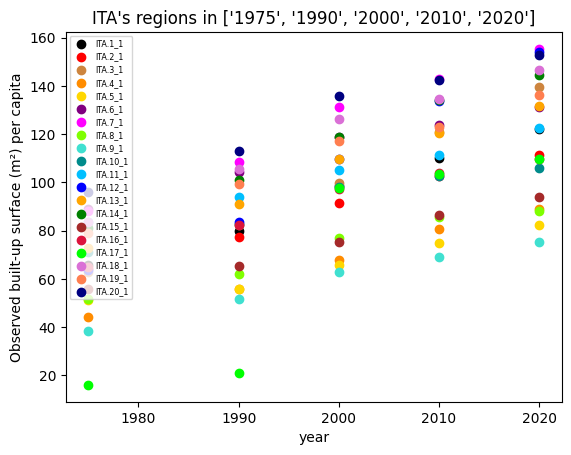

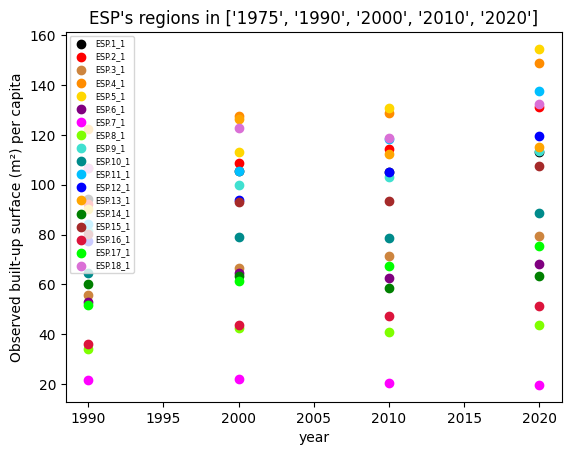

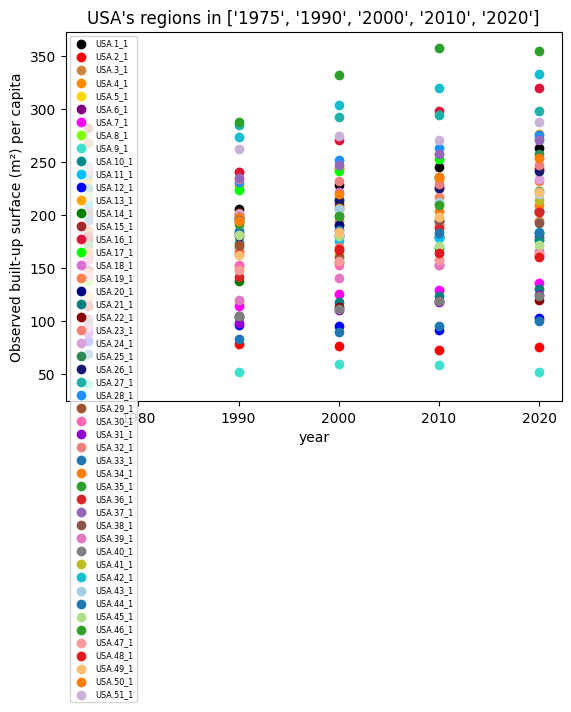

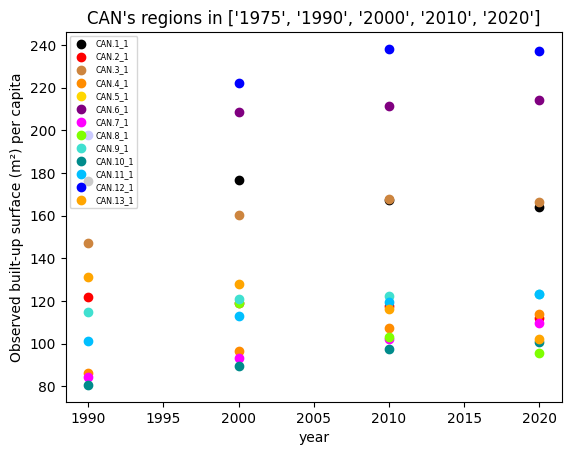

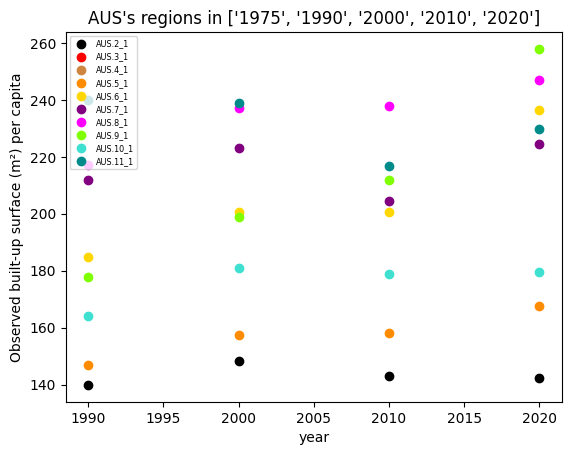

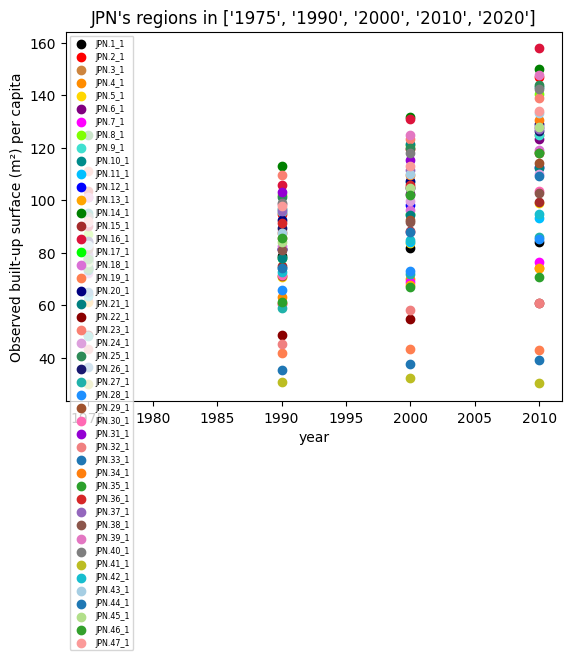

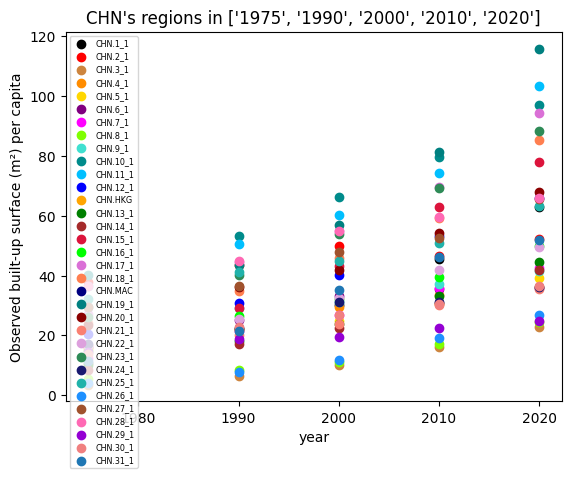

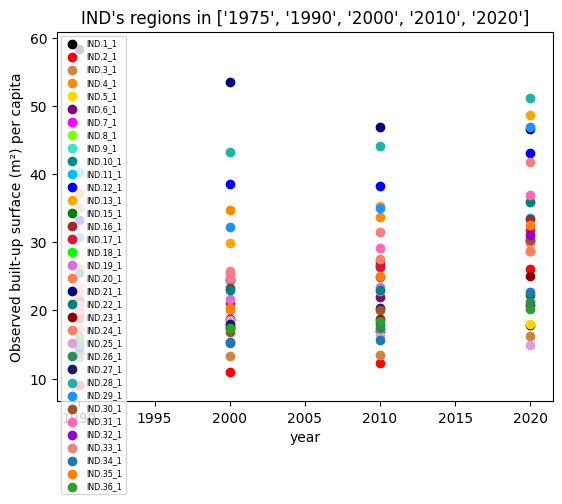

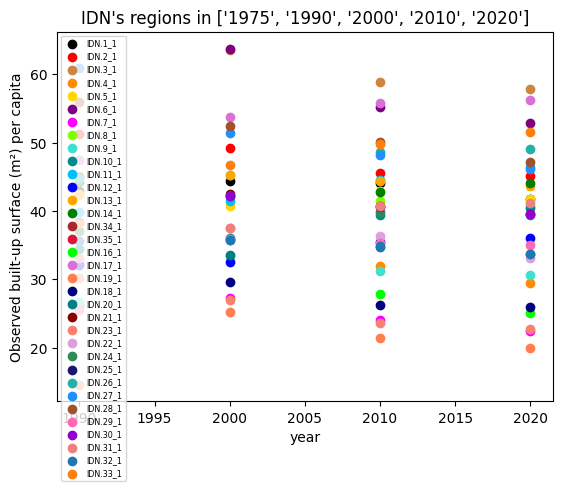

In [17]:
if True:
    x_col = "year"
    y_col = "Built up surface GHSL"
    pop_col = "pop"

    for region in regions:
        k = 0
        try:
            for subregion in region.subregions:
                
                filtered_df = subregion.output_df_merged.dropna(subset=[x_col, pop_col, y_col])
                x = filtered_df[x_col]
                pop = filtered_df[pop_col]
                y = filtered_df[y_col]               
        
                plt.scatter(x, y/pop, color=colors_reg[k % len(colors_reg)], label=subregion.name) #, alpha=(i+1)/6)
        
                k = k + 1
        
            plt.title(region.name + "'s regions in " + str(years))
            plt.ylabel("Observed built-up surface (m²) per capita")
            plt.xlabel("year")
            plt.legend(loc="upper left", prop=fontP)
            plt.show()
        except Exception as e:
            print(region.name, "\n", e)

### PLOT 1.2 : Observable per capita compared to grp_pc_usd_2015

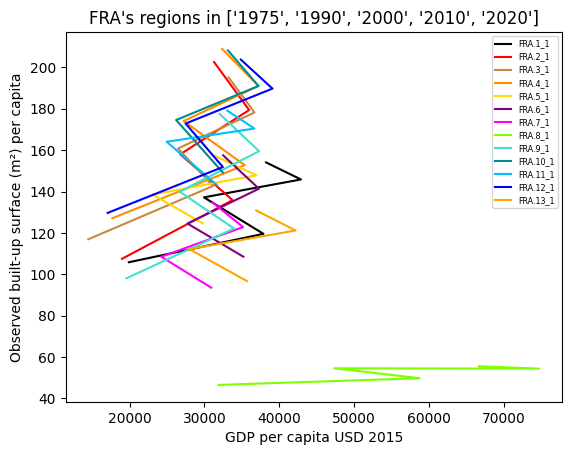

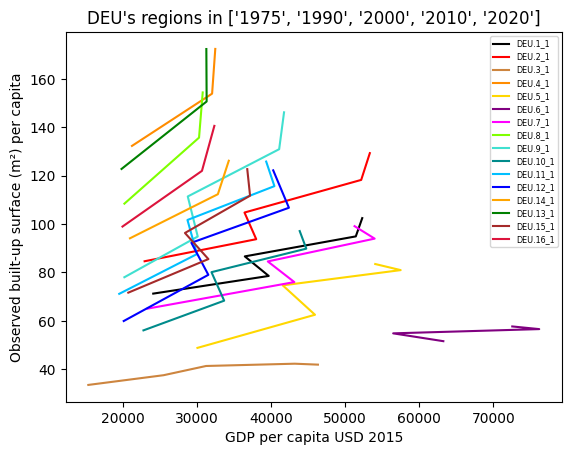

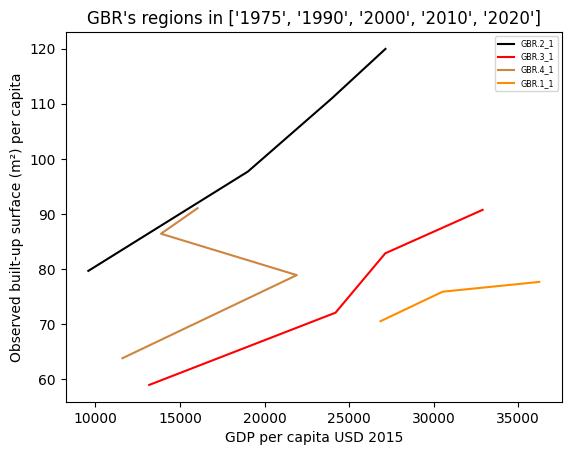

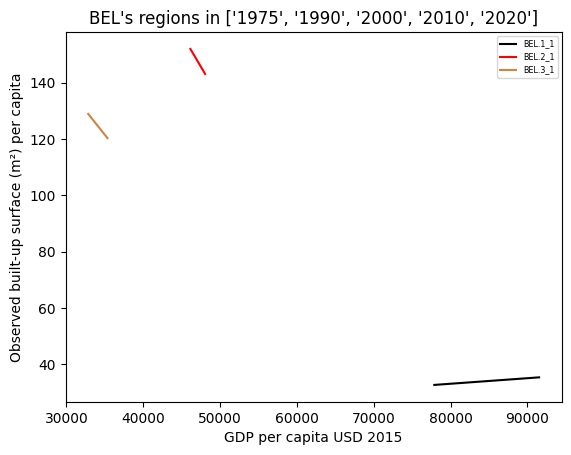

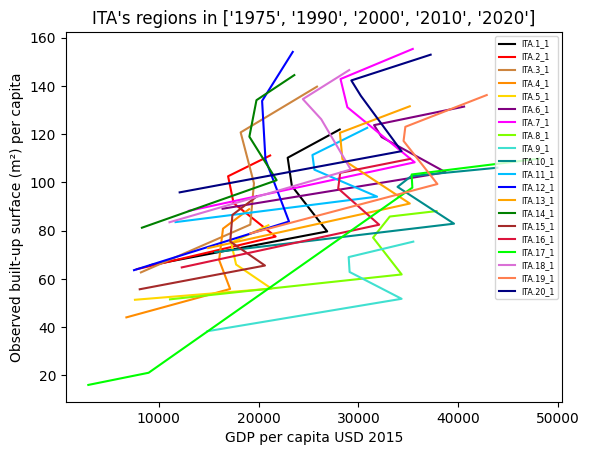

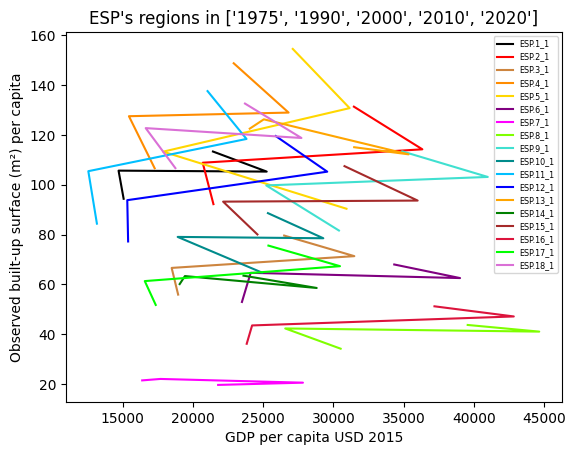

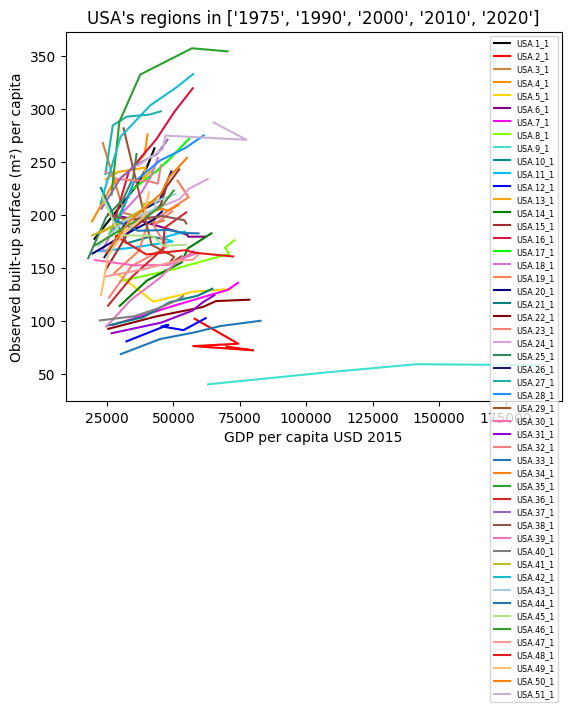

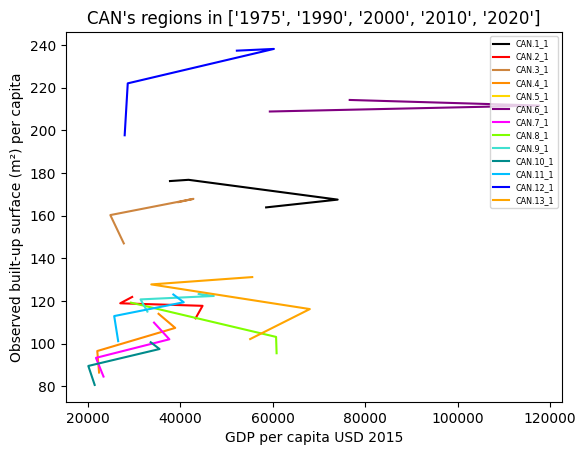

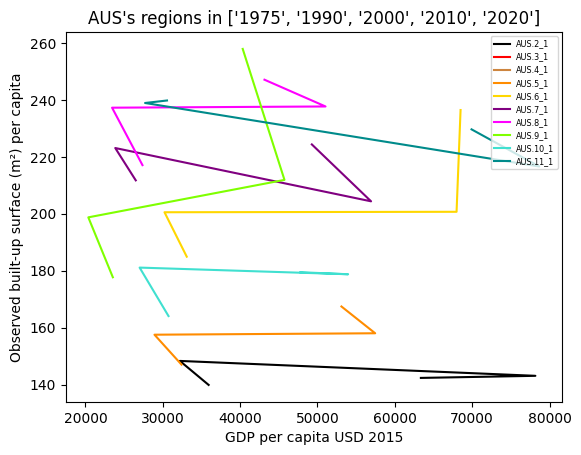

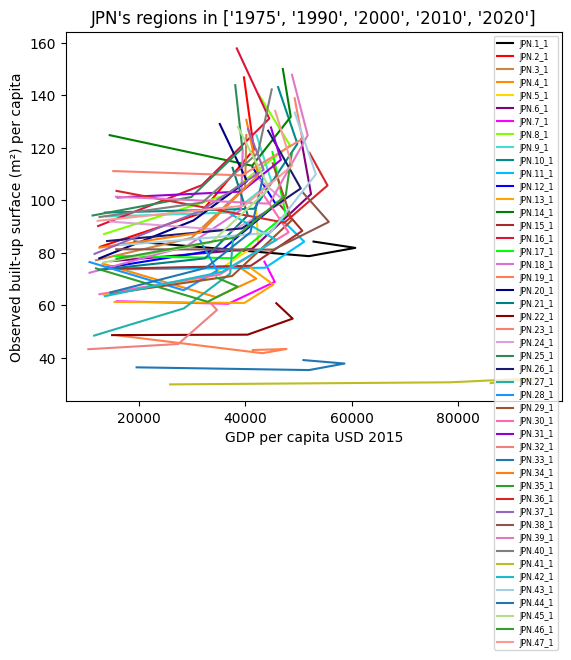

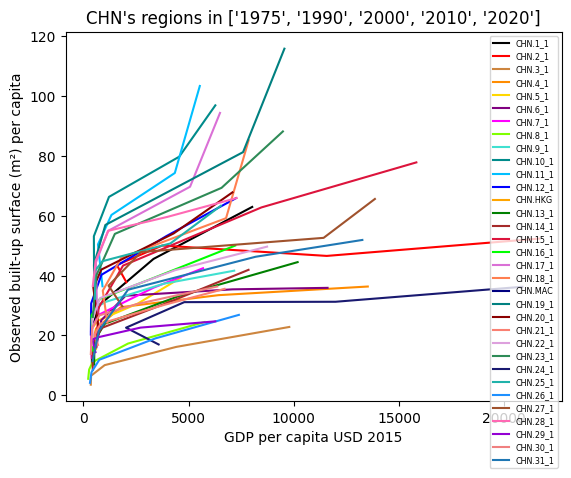

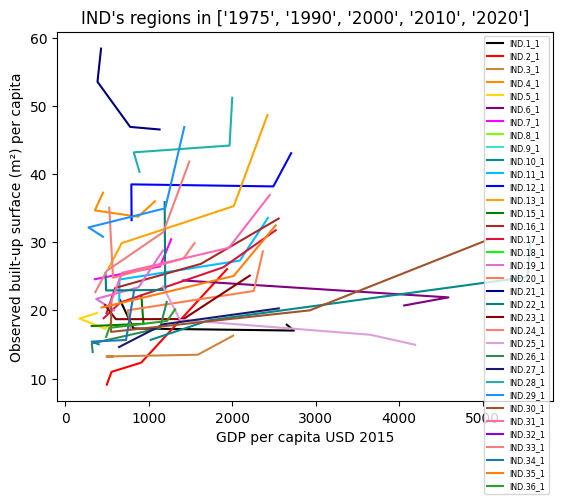

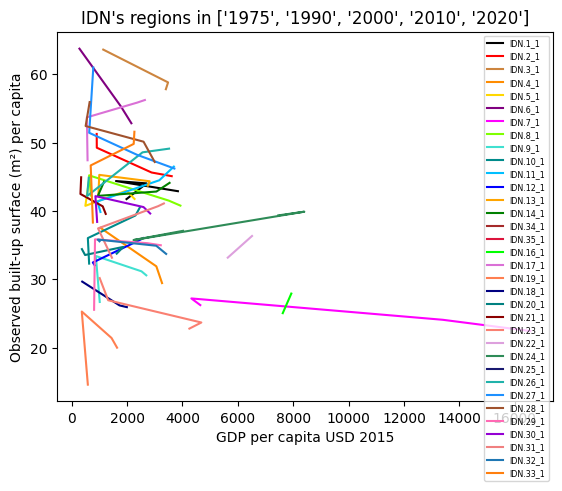

In [18]:
if True:
    x_col = "grp_pc_usd_2015"
    y_col = "Built up surface GHSL"
    pop_col = "pop"

    for region in regions:
        k = 0
        try:
            for subregion in region.subregions:
                
                filtered_df = subregion.output_df_merged.dropna(subset=[x_col, pop_col, y_col])
                x = filtered_df[x_col]
                y = filtered_df[y_col]
                pop = filtered_df[pop_col]
        
                plt.plot(x, y/pop, color=colors_reg[k % len(colors_reg)], label=subregion.name) #, alpha=(i+1)/6)
        
                k = k + 1
            
            plt.title(region.name + "'s regions in " + str(years))
            plt.ylabel("Observed built-up surface (m²) per capita")
            plt.xlabel("GDP per capita USD 2015")
            plt.legend(loc="upper right", prop=fontP)
            plt.show()
        except Exception as e:
            print(region.name, "\n", e)

### PLOT 1.3 : Observable per capita compared to observable fraction (m2 built up / all m2)

In [19]:
if False:    
    x_col = "Built up surface fraction"
    y_col = "Built up surface GHSL/Population_OECD"

    for region in regions:
        k = 0
        try:
            for subregion in region.subregions:
                
                filtered_df = subregion.output_df_merged.dropna(subset=[x_col, y_col])
                x = filtered_df[x_col]
                y = filtered_df[y_col]
        
                plt.scatter(x, y, color=colors_reg[k % len(colors_reg)], label=subregion.name) #, alpha=(i+1)/6)
        
                k = k + 1
        
            plt.title(region.name + "'s regions in " + str(years))
            plt.ylabel("Observed built-up surface (m²) per capita")
            plt.xlabel("Built up surface fraction")
            plt.legend(loc="upper right", prop=fontP)
            plt.show()
        except Exception as e:
            print(region.name, "\n", e)

### PLOT 1.4 : Observable per capita compared to population density

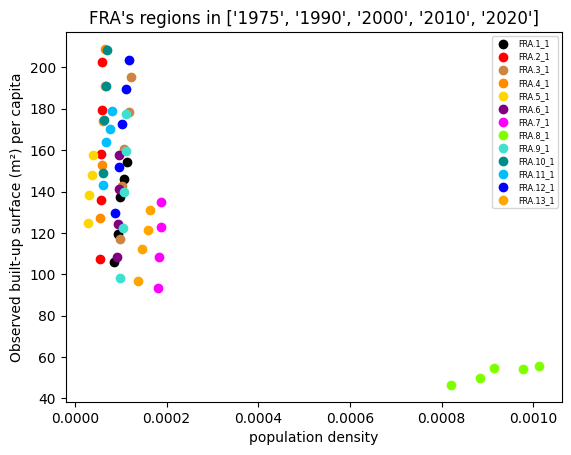

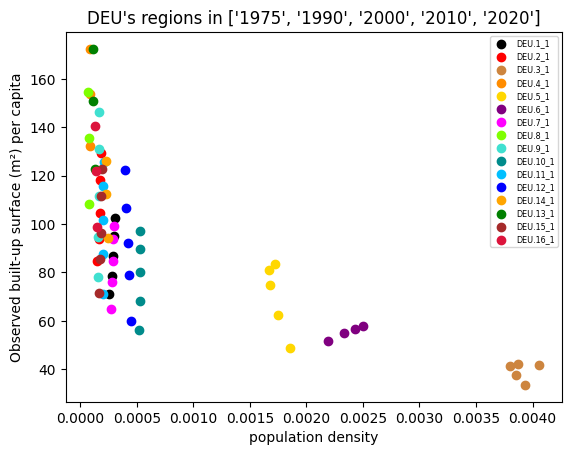

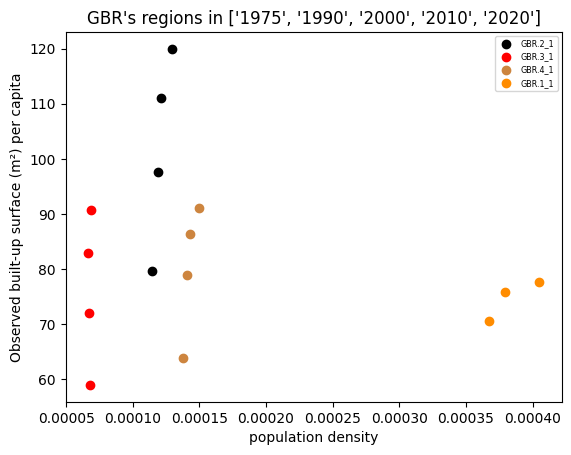

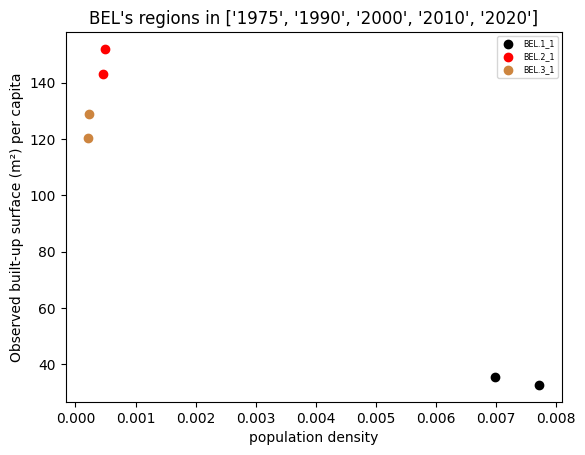

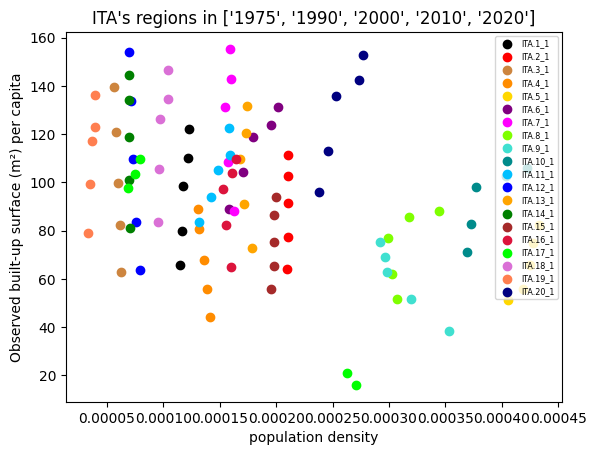

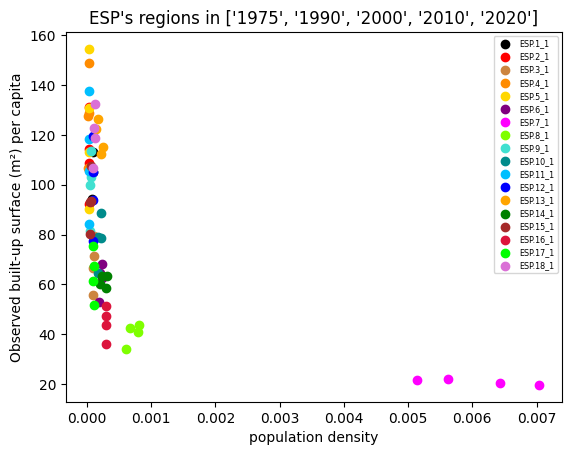

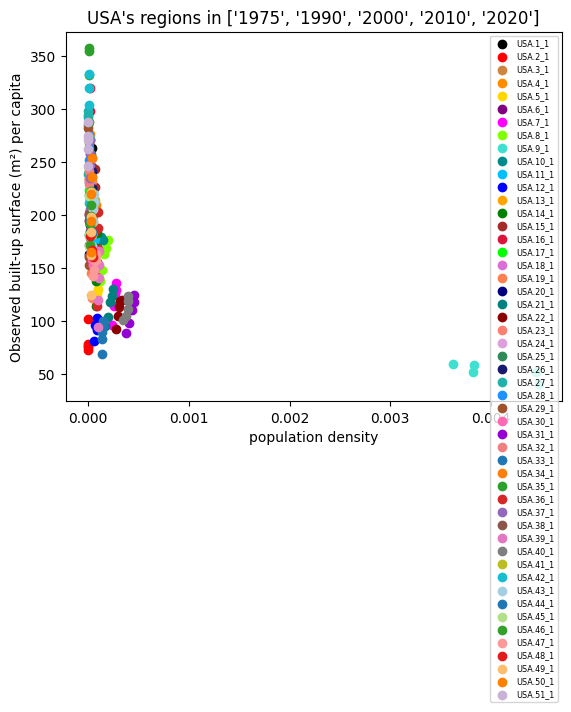

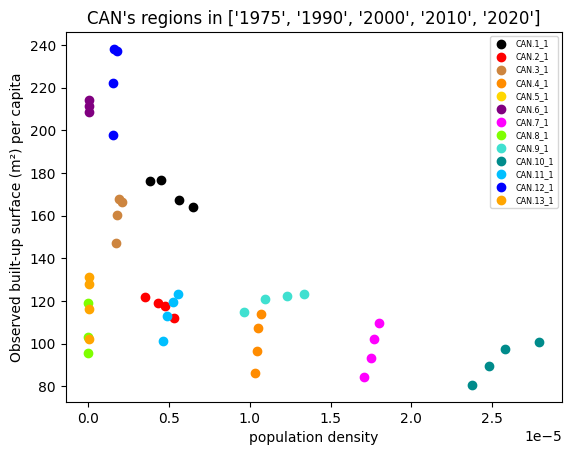

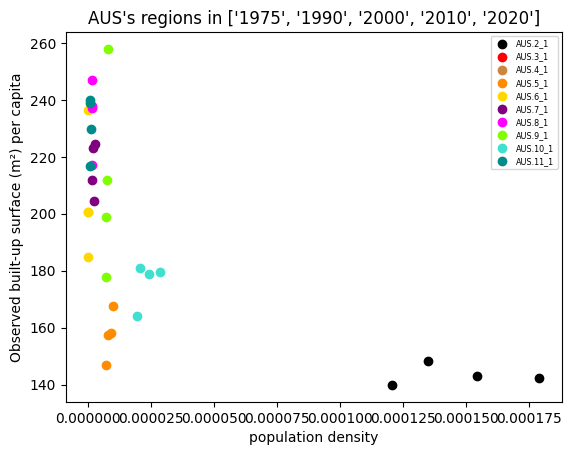

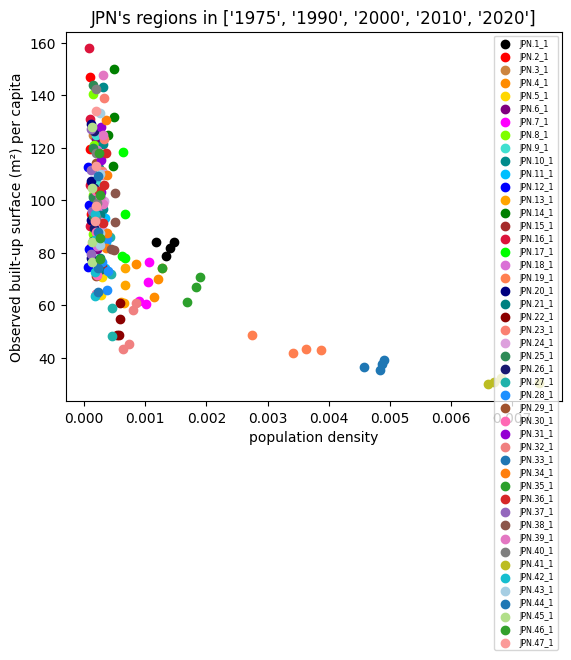

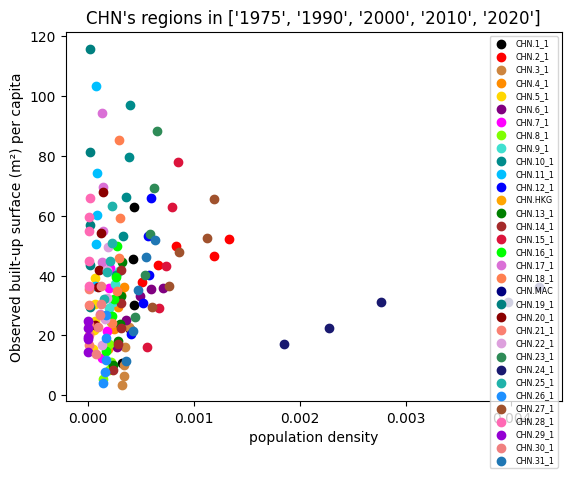

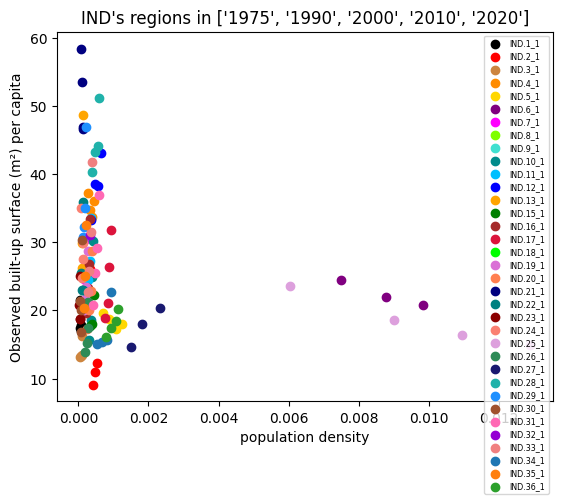

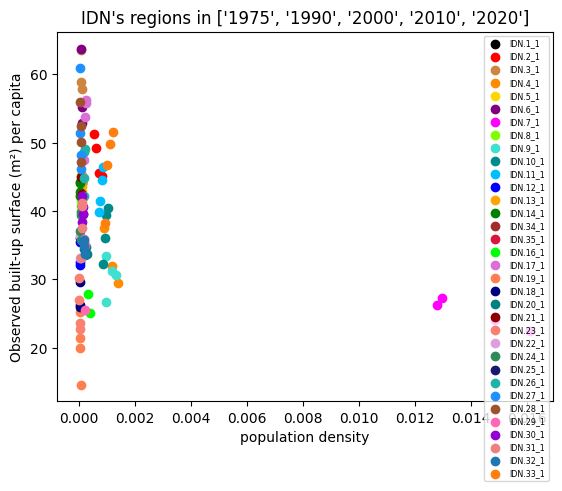

In [20]:
if True: 
    x_col = "Total surface"
    y_col = "Built up surface GHSL"
    pop_col = "pop"

    for region in regions:
        k = 0
        try:
            for subregion in region.subregions:
                
                filtered_df = subregion.output_df_merged.dropna(subset=["year", x_col, pop_col, y_col])
                x = filtered_df[x_col]
                y = filtered_df[y_col]
                pop = filtered_df[pop_col]
        
                plt.scatter(pop/x, y/pop, color=colors_reg[k % len(colors_reg)], label=subregion.name) #, alpha=(i+1)/6)
            
                k = k + 1
        
            plt.title(region.name + "'s regions in " + str(years))
            plt.ylabel("Observed built-up surface (m²) per capita")
            plt.xlabel("population density")
            plt.legend(loc="upper right", prop=fontP)
            plt.show()
        except Exception as e:
            print(region.name, "\n", e)

## PART 4 : Fitting

The fitting part consists of several parts. We do the fits in seperate steps for two reasons. First because the fits are better if we feed it with coherent initial parameter values. Secondly because it is best for us to get a clear picture of what are fitted functions look like.

1. We fit the classical logistic part only (observable/cap vs GDP/cap) region by region to get an idea of appropriate fit parameter values.

2. We fit the exponential decay part only (observable/cap vs population density) for one year to get an idea of appropriate fit parameter values.

3. We fit the Spatio Temporal Logistic function. In order to have better results, we start the fitting algorithm with initial parameter values close to the one found in the first two step described above.

4. 

In [21]:
from Fit import Fit

### PART 4.1 : Fit the logistic only

In [22]:
### To fit the logistic part, we combine all the regional data to get the national mean

df_gdp_cap_region_handler_log = []
df_built_up_region_handler_log = []

x_col1 = "grp_pc_usd_2015"
y_col = "Built up surface GHSL"
pop_col = "pop"

for region in regions:
    df_gdp_cap_region = [0]
    df_built_up_region = [0]    

    for y in years:
        total_pop = 0
        total_surface = 0
        total_gdp = 0
        for subregion in region.subregions:
            try:
                filtered_df = subregion.output_df_merged.dropna(subset=["year", x_col1, pop_col, y_col])
                filtered_df = filtered_df[filtered_df["year"] == int(y)]
                total_gdp += (filtered_df[x_col1].values[0] * filtered_df[pop_col].values[0])
                total_surface += filtered_df[y_col].values[0]
                total_pop += filtered_df[pop_col].values[0]
            except Exception as e : 
                # print(e)
                pass

        if total_gdp != 0:
            df_gdp_cap_region.append(total_gdp/total_pop)
            df_built_up_region.append(total_surface/total_pop)
        else:
            # df_gdp_cap_region.append(0)
            # df_built_up_region.append(0)
            print(colored(f"No data for {region.name} at {y}", "yellow"))

    if df_gdp_cap_region and df_built_up_region:
        df_gdp_cap_region_handler_log.append(df_gdp_cap_region)
        df_built_up_region_handler_log.append(df_built_up_region)
    else:
       df_gdp_cap_region_handler_log.append([0, 0])
       df_built_up_region_handler_log.append([0, 0])
       print(region.name, " is  empty and won't be fitted")

No data for GBR at 2020
No data for BEL at 1975
No data for BEL at 1990
No data for BEL at 2000
No data for ESP at 1975
No data for CAN at 1975
No data for AUS at 1975
No data for JPN at 2020
No data for IND at 1975
No data for IDN at 1975


In [23]:
# fit logistic over time, region by region
logistic_fit_handler = []

j = -1
for region in regions:
    j = j + 1
        
    logistic_fit_handler.append(Fit(region.name + "_logistic", np.array(df_gdp_cap_region_handler_log[j]), [0,0], np.array(df_built_up_region_handler_log[j])))
    logistic_fit_handler[-1].fit_logistic(init=[100, 0.00001, 15000])
    print(colored(region.name, "green"))
    print(logistic_fit_handler[-1].fitted_params)
    print("R squared : ", colored( round(logistic_fit_handler[-1].r_squared,2), "red"), )
        #   "\n-----------------------------------------------------------------------")

FRA
[135.3208946207038, 0.00022350027609770927, 19824.69465074131]
R squared :  0.95
DEU
[109.52403459221253, 0.0001258275338295592, 20330.38939254404]
R squared :  0.94
GBR
[76.83246065987775, 0.0007244942941759034, 9922.586940710864]
R squared :  0.99
BEL
[128.46879026747945, 0.0016314363907627197, 8312.443007092797]
R squared :  1.0
ITA
[97.25523933617409, 0.0011067014255064962, 10503.595481466706]
R squared :  0.92
ESP
[86.48219904188184, 0.0002919220545054743, 12808.606491186705]
R squared :  0.96
USA
[171.94816586356714, 0.00019759567920088416, 18230.181202587373]
R squared :  0.99
CAN
[130.51145435456036, 0.0002740967353391494, 18912.319245550294]
R squared :  1.0
AUS
[187.81064900874472, 0.001809569353198977, 7456.843135110331]
R squared :  0.99
JPN
[78.41408802619137, 0.0007663585252745161, 13505.484023676674]
R squared :  0.96
CHN
[51.18420528058722, 0.002462835733631112, 749.7581137259021]
R squared :  0.91
IND
[25.604034161501982, 0.009806592170768852, 369.0253573560157]
R 

/home/hautervo/Documents/GitHub/spatialization_module/Fit.py:91: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(


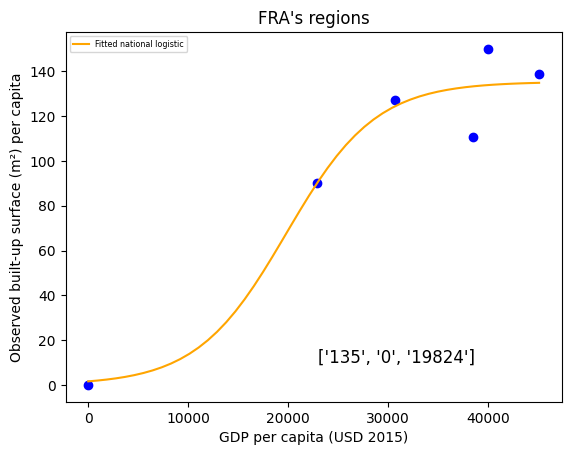

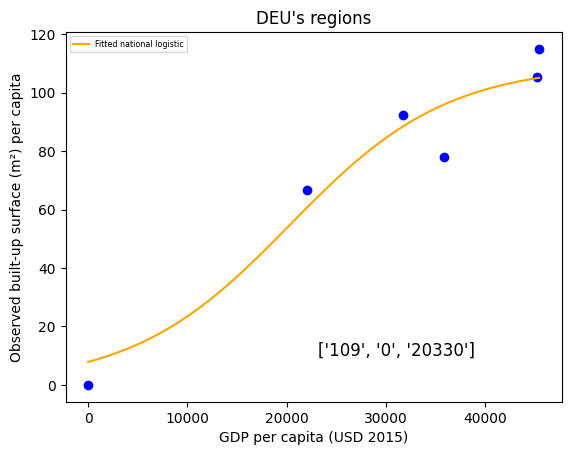

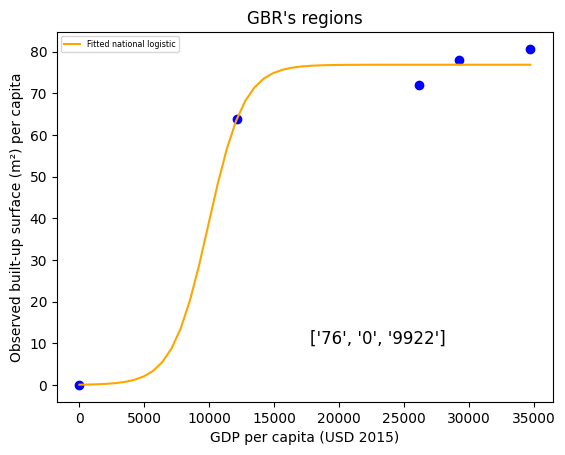

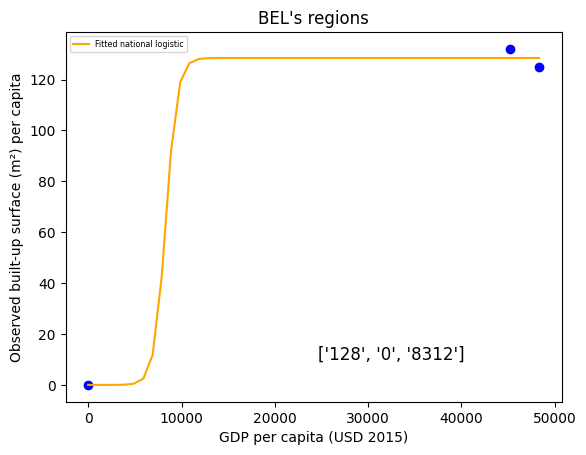

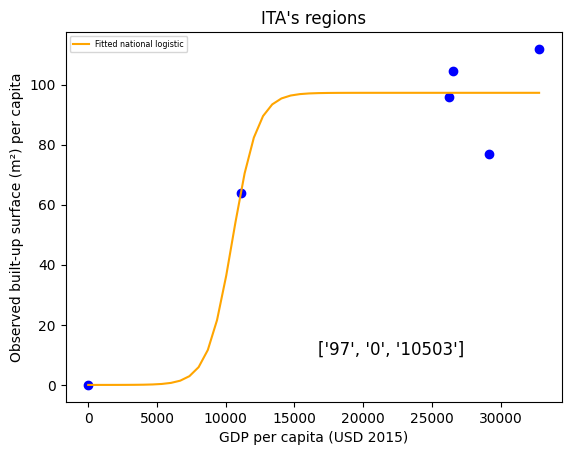

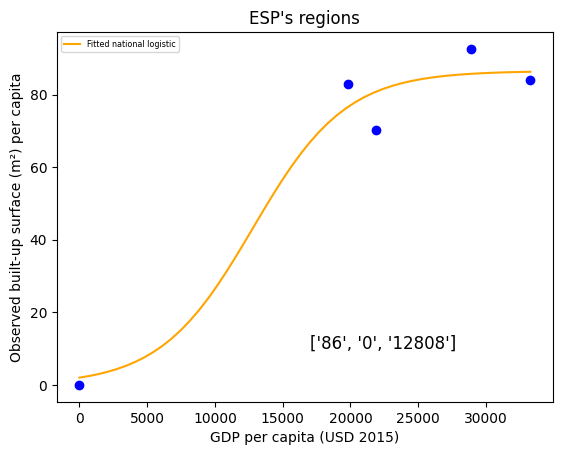

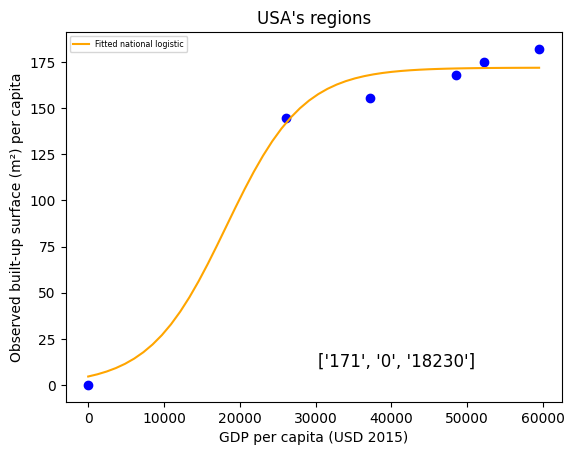

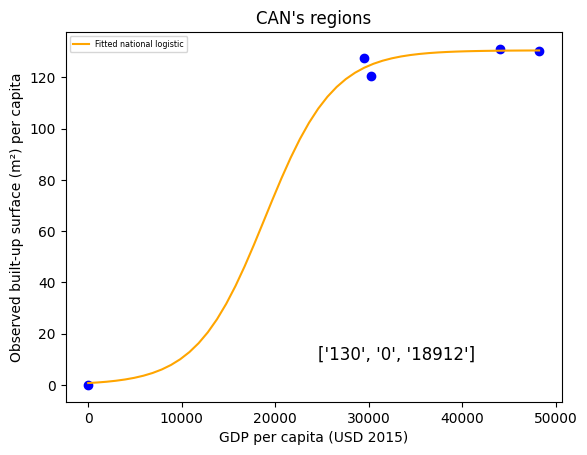

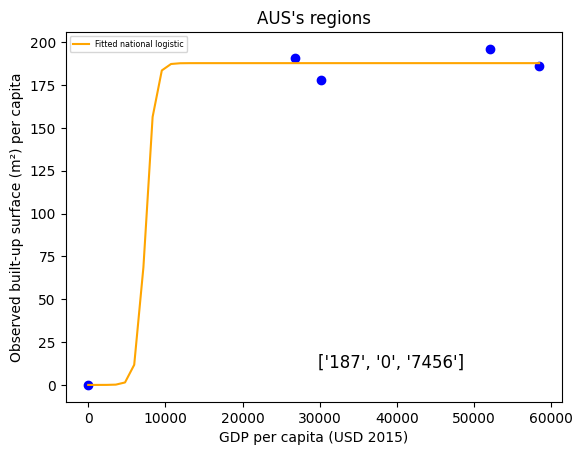

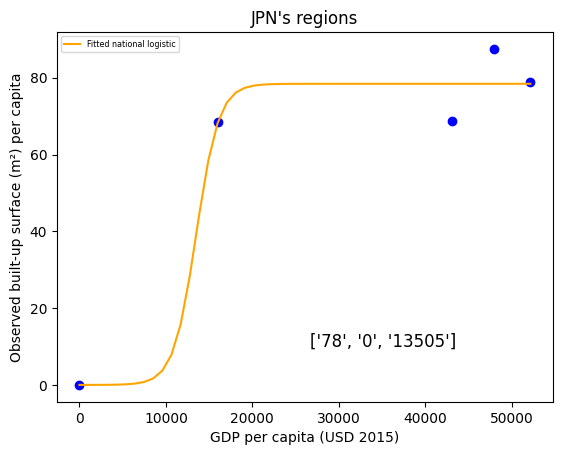

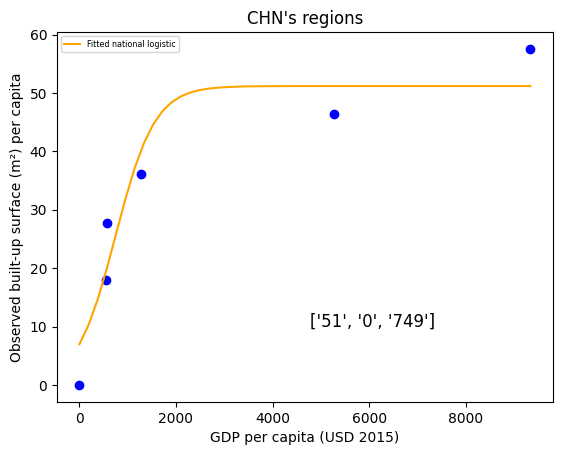

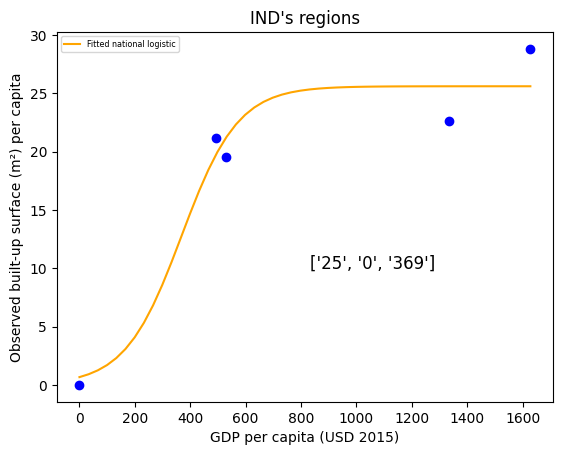

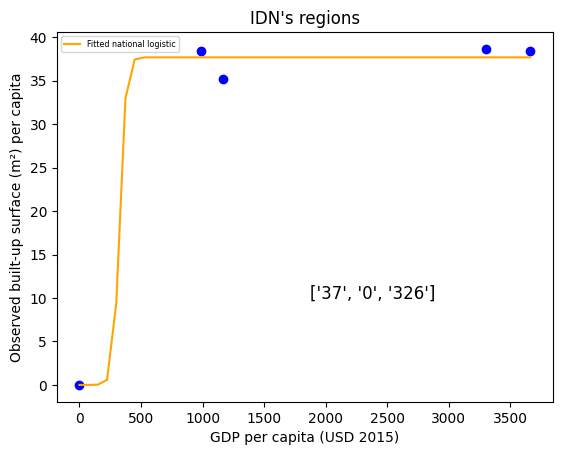

In [24]:
# # PLOT verification

j=0
for region in regions:
    x_fit_array = np.linspace(min(df_gdp_cap_region_handler_log[j]), max(df_gdp_cap_region_handler_log[j]), 50)
    fitted_params = [str(int(x)) for x in logistic_fit_handler[j].fitted_params]

    plt.plot(x_fit_array, logistic(x_fit_array, logistic_fit_handler[j].fitted_params[0], logistic_fit_handler[j].fitted_params[1], logistic_fit_handler[j].fitted_params[2]), color='orange',
             label="Fitted national logistic")
    plt.scatter(df_gdp_cap_region_handler_log[j], df_built_up_region_handler_log[j],  color='b')
    plt.text(x_fit_array[25], 10, fitted_params, fontsize=12, color='black')

    plt.title(region.name + "'s regions")
    plt.ylabel("Observed built-up surface (m²) per capita")
    plt.xlabel("GDP per capita (USD 2015)")
    plt.legend(loc="upper left", prop=fontP)
    plt.show()

    j = j + 1

#### PART 4.2 : Fit the saturation only

In [25]:
### To fit the saturation, we consider the last regional data point to fit the exponential over the most recent year

df_pop_density_region_handler_sat = []
df_built_up_region_handler_sat = []

x_col2 = "Total surface"
y_col = "Built up surface GHSL"
pop_col = "pop"

for region in regions:
    df_pop_density_region = []
    df_built_up_region = []
    
    for subregion in region.subregions:
        filtered_df = subregion.output_df_merged.dropna(subset=["year", x_col2, pop_col, y_col])
        if not filtered_df.empty:
            df_pop_density_region.append(filtered_df[pop_col].iloc[-1] / filtered_df[x_col2].iloc[-1])
            df_built_up_region.append(filtered_df[y_col].iloc[-1] / filtered_df[pop_col].iloc[-1])  
        else:
            print(colored(f"No data for subregion: {subregion.name}", "yellow"))


    if df_pop_density_region and df_built_up_region:
        df_pop_density_region_handler_sat.append(df_pop_density_region)
        df_built_up_region_handler_sat.append(df_built_up_region)
    else:
       df_pop_density_region_handler_sat.append([0, 0])
       df_built_up_region_handler_sat.append([0, 0])
       print(region.name, " is  empty and won't be fitted")

No data for subregion: CAN.5_1
No data for subregion: AUS.3_1
No data for subregion: AUS.4_1
No data for subregion: CHN.HKG
No data for subregion: CHN.MAC
No data for subregion: IND.8_1
No data for subregion: IND.9_1
No data for subregion: IND.18_1
No data for subregion: IDN.34_1
No data for subregion: IDN.35_1
No data for subregion: IDN.25_1


In [26]:
# # fit the saturation fct for one year
saturation_fit_handler = []

j = 0
for region in regions:
    # fit rexponential decay
    saturation_fit_handler.append(Fit(region.name + "_exponential", np.array(df_pop_density_region_handler_sat[j]), [0,0], np.array(df_built_up_region_handler_sat[j])))
    saturation_fit_handler[-1].fit_exponential_decay(init=[50, 50]) 

    print(colored(region.name, "green"))
    print(saturation_fit_handler[-1].fitted_params)
    print("R squared for : ", colored(round(saturation_fit_handler[-1].r_squared, 2), "red"))
    j = j + 1


FRA
[204.42129956983408, 1462.9170831996805]
R squared for :  0.71
DEU
[144.87201091434727, 390.00653909220614]
R squared for :  0.76
GBR
[108.4261604211125, 733.0775806200812]
R squared for :  0.32
BEL
[149.3800922273828, 188.81046013457748]
R squared for :  0.94
ITA
[146.2765791085802, 1101.1026738538455]
R squared for :  0.33
ESP
[140.29455835484518, 2290.713395003461]
R squared for :  0.73
USA
[242.91024909016284, 2506.7204755843118]
R squared for :  0.42
CAN
[149.67260598229166, 9999.999999999616]
R squared for :  0.15
AUS
[226.3509474014398, 2945.672348272966]
R squared for :  0.55
JPN
[131.6581795984758, 382.92308396651833]
R squared for :  0.62
CHN
[58.04849777208615, 65.06851013952216]
R squared for :  0.01
IND
[32.316283858911014, 63.64190118219522]
R squared for :  0.15
IDN
[40.09464873783732, 34.17627196681925]
R squared for :  0.1


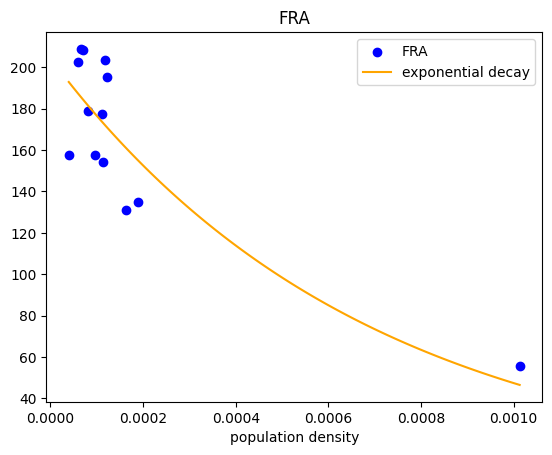

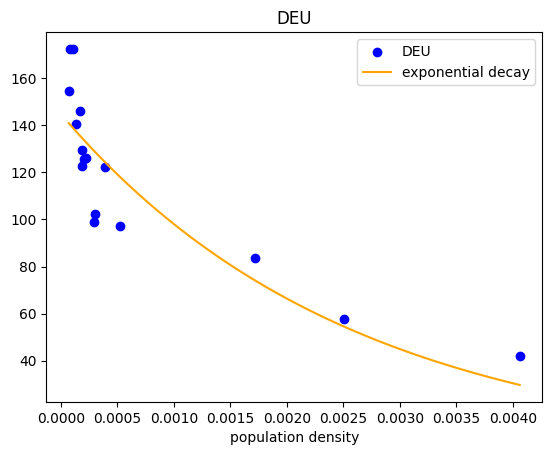

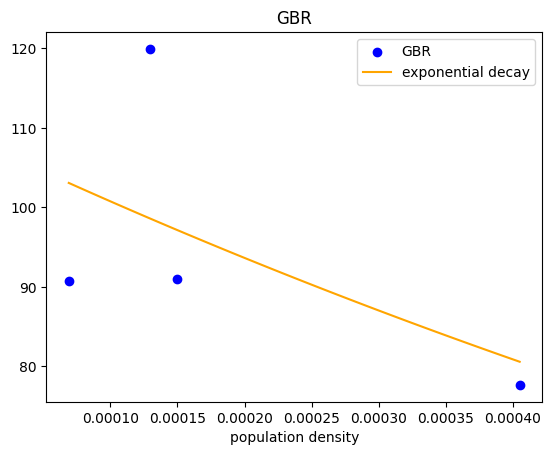

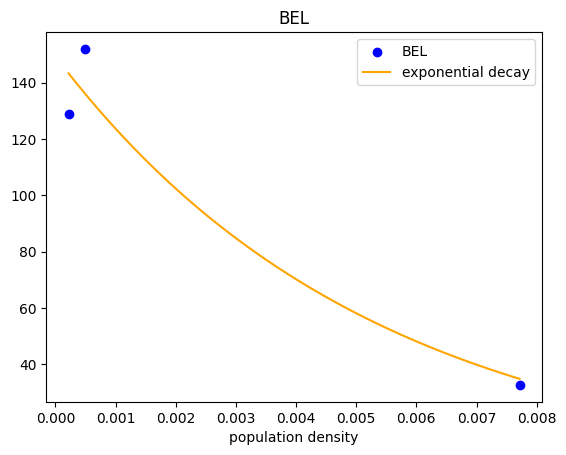

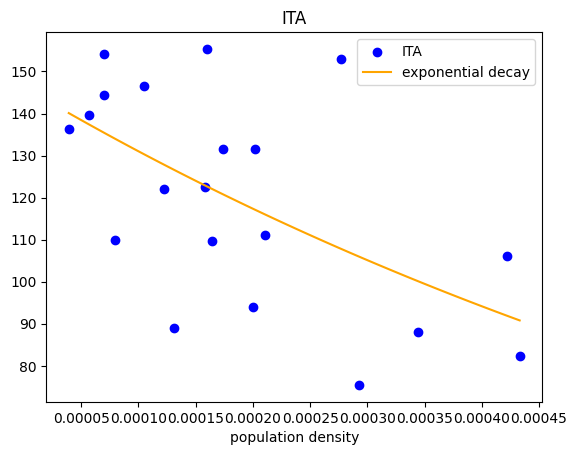

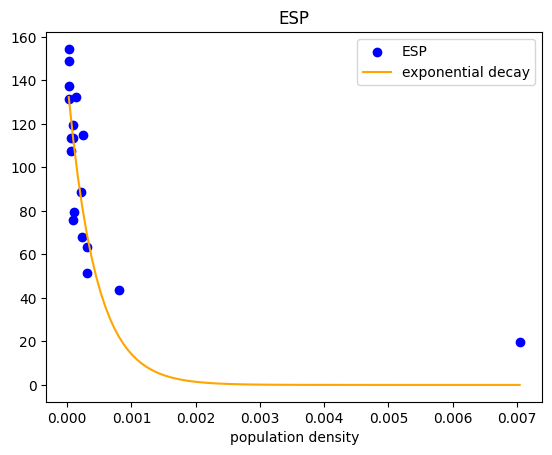

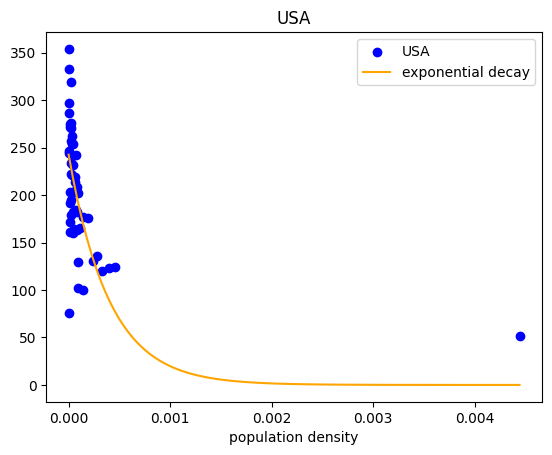

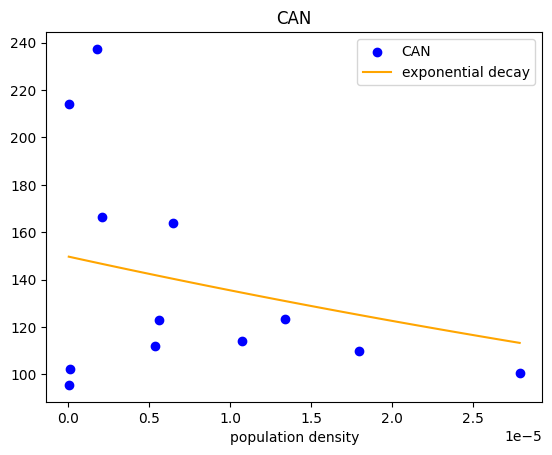

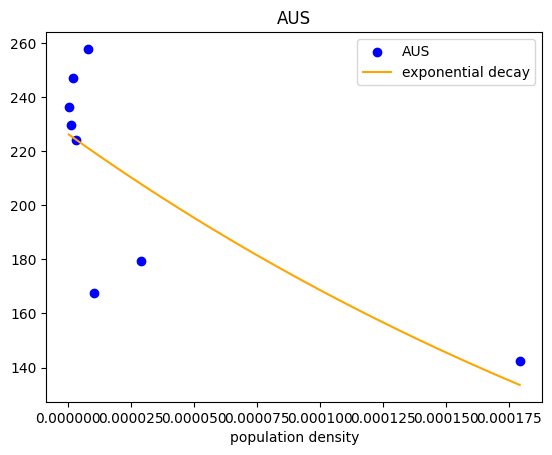

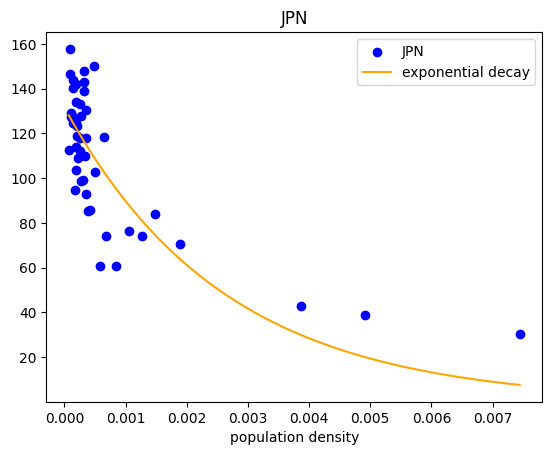

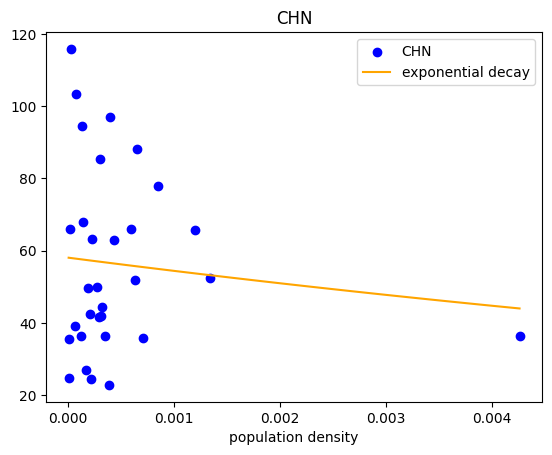

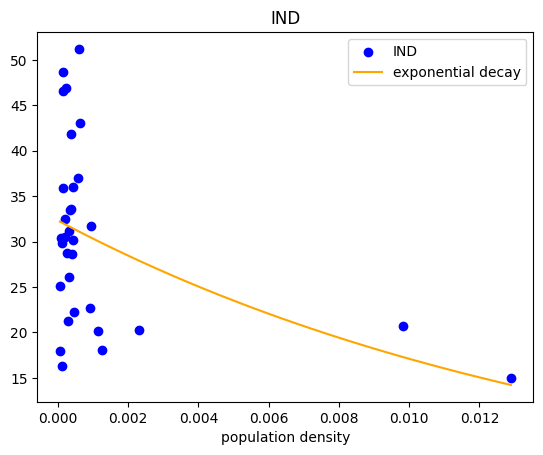

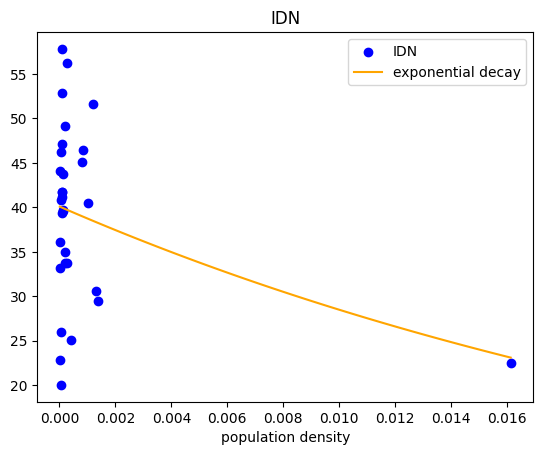

In [27]:
#  PLOT verification
j = 0
for region in regions:
    x_fit_array = np.linspace(min(df_pop_density_region_handler_sat[j]), max(df_pop_density_region_handler_sat[j]), 10)
    plt.scatter(df_pop_density_region_handler_sat[j], df_built_up_region_handler_sat[j],  color="b",
            label=region.name)
    plt.plot(saturation_fit_handler[j].x1_fit, saturation_fit_handler[j].y_fit, label="exponential decay", color="orange") 
    plt.xlabel("population density")
    plt.legend(loc="upper right")
    plt.title(region.name)
    plt.show()
    j = j + 1

### PART 4.3 : Fit of the Spatio Temporal Logistic function

Now that we have an idea of the parameters and their fitness we can derive parameters for the Spatio Temporal Logistic function as a whole. For this, we concatenate all our points, all regions, all years.

In [28]:
# # Concatenate all the data points

df_gdp_cap_region_handler = []
df_pop_density_region_handler = []
df_built_up_region_handler = []

x_col1 = "grp_pc_usd_2015"
x_col2 = "Total surface"
y_col = "Built up surface GHSL"
pop_col = "pop"

for region in regions:
    df_gdp_cap_region = []
    df_pop_density_region = []
    df_built_up_region = []    

    for subregion in region.subregions:
        
        filtered_df = subregion.output_df_merged.dropna(subset=["year", x_col1, x_col2, pop_col, y_col])
        df_gdp_cap_region = df_gdp_cap_region + filtered_df[x_col1].to_list()
        df_pop_density_region = df_pop_density_region + (filtered_df[pop_col] / filtered_df[x_col2]).to_list()
        df_built_up_region = df_built_up_region + (filtered_df[y_col] / filtered_df[pop_col]).to_list()      

    if df_gdp_cap_region and df_pop_density_region and df_built_up_region:
        df_gdp_cap_region_handler.append(df_gdp_cap_region)
        df_pop_density_region_handler.append(df_pop_density_region)
        df_built_up_region_handler.append(df_built_up_region)
    else:
       df_gdp_cap_region_handler.append([0, 0])
       df_pop_density_region_handler.append([0, 0])
       df_built_up_region_handler.append([0, 0])
       print(region.name, " is  empty and won't be fitted")

In [29]:
# Fit STL logistic with density
# This is the automatic fit
STL_fit_handler = []

for i in range(len(regions)):
    try:
        STL_fit_handler.append(Fit("tmp", np.array(df_gdp_cap_region_handler[i]), np.array(df_pop_density_region_handler[i]), np.array(df_built_up_region_handler[i])))
        STL_fit_handler[-1].fit_STL(init=[10, 30, 0.00001, 6000])
    
        print(colored(regions[i].name, "green"))
        print(STL_fit_handler[-1].fitted_params)
        print("R squared : ", colored(round(STL_fit_handler[-1].r_squared, 2), "red"))
    except Exception as e:
        print(regions[i].name, "\n", e)

FRA
[168.9423496773321, 1342.374533627226, 0.2683851315082263, 6768.746388705773]
R squared :  0.51
DEU
[124.58681430046084, 366.20938113104336, 0.00018733506578441514, 14170.585512998598]
R squared :  0.58
GBR
[99.10764329320357, 545.0901337389012, 0.00016891932091741134, 3464.1269094538115]
R squared :  0.22
BEL
[144.51096045537923, 189.4103770416854, 0.06544275579370282, 5059.186746129416]
R squared :  0.93
ITA
[136.41343738769106, 1086.659792113903, 0.00014968522114062327, 8464.99797414494]
R squared :  0.53
ESP
[117.49246683925662, 2077.8643939088442, 0.02326122933593234, 5314.285806713401]
R squared :  0.57
USA
[220.0449353272547, 2822.7996773283585, 0.0040501862188644265, 5346.87781679435]
R squared :  0.4
CAN
[307.3891468677499, 9999.999999999998, 1.1798078073982837e-05, 51047.55277972019]
R squared :  0.34
AUS
[209.13523484592613, 2868.3313445948806, 0.0020033034064043356, 5151.174077080672]
R squared :  0.42
JPN
[258.82733349780926, 297.02219031567677, 1.5665817226269624e-05,

Now that we have the fitted params for the spatio temporal logistic, we can compare them with the ones we found indepently for the logsitic and the exponential fits.

In [30]:
for i in range(len(regions)):
    try:    
        print(colored(regions[i].name, "green"))
        print(STL_fit_handler[i].fitted_params)
        print([saturation_fit_handler[i].fitted_params[0],saturation_fit_handler[i].fitted_params[1],logistic_fit_handler[i].fitted_params[1],logistic_fit_handler[i].fitted_params[2],])
    except Exception as e:
        print(regions[i].name, "\n", e)

FRA
[168.9423496773321, 1342.374533627226, 0.2683851315082263, 6768.746388705773]
[204.42129956983408, 1462.9170831996805, 0.00022350027609770927, 19824.69465074131]
DEU
[124.58681430046084, 366.20938113104336, 0.00018733506578441514, 14170.585512998598]
[144.87201091434727, 390.00653909220614, 0.0001258275338295592, 20330.38939254404]
GBR
[99.10764329320357, 545.0901337389012, 0.00016891932091741134, 3464.1269094538115]
[108.4261604211125, 733.0775806200812, 0.0007244942941759034, 9922.586940710864]
BEL
[144.51096045537923, 189.4103770416854, 0.06544275579370282, 5059.186746129416]
[149.3800922273828, 188.81046013457748, 0.0016314363907627197, 8312.443007092797]
ITA
[136.41343738769106, 1086.659792113903, 0.00014968522114062327, 8464.99797414494]
[146.2765791085802, 1101.1026738538455, 0.0011067014255064962, 10503.595481466706]
ESP
[117.49246683925662, 2077.8643939088442, 0.02326122933593234, 5314.285806713401]
[140.29455835484518, 2290.713395003461, 0.0002919220545054743, 12808.60649

At this step, we successfully fitted the function STL to all our available data. But, as we may want to use different values for the rest of our study, it is good to save the values of the study. For example, if I want to see if the values found on FRA are consistent with data from DEU, I may continue with the fitted parameters of FRA even though my current study is on DEU.

## PART 5 : the STL function fit

### PART 5.1 : 3D Plot with one equation for one country

The surface is the fitted Spatio Temporal logistic function.
The points are the data

In [31]:
# The automatic fit is the fit made via the python module scikit. 
# This is numerically the best fit but it may be further away that what we want because it
# follows to rigorously the data.
# If True, we will use the STL_fit parameters.
# If False, we will use both the fitted parameters from the logistic-only part and the saturation-only part combined.

use_automatic_fit = True

In [32]:
three_D_plots = False

In [33]:
if three_D_plots:
    import plotly.graph_objects as go

    for j in range(len(regions)):
        try:
            # Create a meshgrid of x and y values
            x = np.linspace(0.5*min(df_gdp_cap_region_handler[j]), 1.5*max(df_gdp_cap_region_handler[j]), 50)
            y = np.linspace(0.5*min(df_pop_density_region_handler[j]), 1.5*max(df_pop_density_region_handler[j]), 50)
            x_grid, y_grid = np.meshgrid(x, y)

            if use_automatic_fit:
                z = STL([x_grid,y_grid], STL_fit_handler[j].fitted_params[0], STL_fit_handler[j].fitted_params[1], STL_fit_handler[j].fitted_params[2], STL_fit_handler[j].fitted_params[3])
            else: 
                z = STL([x_grid,y_grid], saturation_fit_handler[j].fitted_params[0], saturation_fit_handler[j].fitted_params[1], logistic_fit_handler[j].fitted_params[1], logistic_fit_handler[j].fitted_params[2])
            
            cmin = np.min(z)
            cmax = np.max(z)
            
            # Create the surface plot using Plotly
            fig = go.Figure(data=[
                go.Surface(
                    z=z, 
                    x=x_grid, 
                    y=y_grid, 
                    colorscale="Turbo", 
                    cmin=cmin,
                    cmax=cmax,
                    opacity=0.4),
                go.Scatter3d(
                    x=df_gdp_cap_region_handler[j], y=df_pop_density_region_handler[j], z=df_built_up_region_handler[j],
                    mode='markers',  # Use 'markers' for scatter plot
                    marker=dict(
                        size=6,  # Size of the points
                        color=df_built_up_region_handler[j],  # Color of the points
                        colorscale='Turbo',  # Colorscale for the points
                        cmin=cmin,
                        cmax=cmax,
                        opacity=1.0
                    )
                ),
                
                ]
                )
        
            # Customize the layout
            fig.update_layout(title=f'3D STL\'s function {regions[j].name}',
                            scene=dict(
                                xaxis_title='grp_pc_usd_2015',
                                yaxis_title='population density',
                                zaxis_title='m2 per capita'
                            ),
                            width=800, height=700)
        
            # Show the plot
            fig.show()
        except Exception as e:
            print(region.name, "\n", e)

### PART 5.2 : 3D Plot with only one equation for every country

Now we want to compare all the countries to only one fit.

In [34]:
if three_D_plots:    
    best_region_fit = 0

    if use_automatic_fit:
        global_STL_fit_params = STL_fit_handler[best_region_fit].fitted_params
    else: 
        global_STL_fit_params = [saturation_fit_handler[best_region_fit].fitted_params[0], saturation_fit_handler[best_region_fit].fitted_params[1], logistic_fit_handler[best_region_fit].fitted_params[1], logistic_fit_handler[best_region_fit].fitted_params[2]]
            

    # Create a meshgrid of x and y values
    x = np.linspace(0.5*min(df_gdp_cap_region_handler[best_region_fit]), 1.5*max(df_gdp_cap_region_handler[best_region_fit]), 50)
    y = np.linspace(0.5*min(df_pop_density_region_handler[best_region_fit]), 1.5*max(df_pop_density_region_handler[best_region_fit]), 50)
    x_grid, y_grid = np.meshgrid(x, y)

    z = STL([x_grid,y_grid], global_STL_fit_params[0], global_STL_fit_params[1], global_STL_fit_params[2], global_STL_fit_params[3])    

    cmin = np.min(z)
    cmax = np.max(z)

    for j in range(len(regions)):
        try:
            
            
            # Create the surface plot using Plotly
            fig = go.Figure(data=[
                go.Surface(
                    z=z, 
                    x=x_grid, 
                    y=y_grid, 
                    colorscale="Turbo", 
                    cmin=cmin,
                    cmax=cmax,
                    opacity=0.4),
                go.Scatter3d(
                    x=df_gdp_cap_region_handler[j], y=df_pop_density_region_handler[j], z=df_built_up_region_handler[j],
                    mode='markers',  # Use 'markers' for scatter plot
                    marker=dict(
                        size=6,  # Size of the points
                        color=df_built_up_region_handler[j],  # Color of the points
                        colorscale='Turbo',  # Colorscale for the points
                        cmin=cmin,
                        cmax=cmax,
                        opacity=1.0
                    )
                ),
                
                ]
                )
        
            # Customize the layout
            fig.update_layout(title=regions[j].name + "'s regions fitted with " + regions[best_region_fit].name + "'s equation",
                            scene=dict(
                                xaxis_title='grp_pc_usd_2015',
                                yaxis_title='population density',
                                zaxis_title='m2 per capita'
                            ),
                            width=800, height=700)
        
            # Show the plot
            fig.show()
        except Exception as e:
            print(region.name, "\n", e)

## PART 6 : Predicted vs Observed Plot

To have a better view on the quality of the 3D logistic curve, we plot the predicted value vs the observed value.  
We do this in two steps :

1. The next cell shows the prediction fitted on each individual country. This should result in the best fits.
2. The following cell shows the the prediction with the logistic curve of one predefined country, applied to all the others. This is to see if one equation is sufficient to fit reasonnably all the countries worldwide.

### PART 6.1

In [35]:
# Statistics with the respective equations for each region

for j in range(len(regions)):
    if use_automatic_fit:
        global_STL_fit_params = STL_fit_handler[j].fitted_params
    else:
        global_STL_fit_params = [saturation_fit_handler[j].fitted_params[0],saturation_fit_handler[j].fitted_params[1],logistic_fit_handler[j].fitted_params[1],logistic_fit_handler[j].fitted_params[2],]
    
    obs = df_built_up_region_handler[j]
    pred = STL([np.array(df_gdp_cap_region_handler[j]), np.array(df_pop_density_region_handler[j])], global_STL_fit_params[0], global_STL_fit_params[1], global_STL_fit_params[2], global_STL_fit_params[3])

    print(colored(regions[j].name, "green"))
    print("RMSE: ", round(RMSE(obs, pred), 2))
    print("MAPE: ", round(MAPE(obs, pred), 2))
    print("STDR: ", round(STDR(obs, pred), 2))
    print("BIAS: ", round(BIAS(obs, pred), 2))
    print("R²  : ", round(R_SQ(obs, pred), 2))
    print("PEAR: ", round(PEARSON(obs, pred)[0], 2), " p_value: ", round(PEARSON(obs, pred)[1], 2))

FRA
RMSE:  27.97
MAPE:  16.78
STDR:  27.97
BIAS:  0.08
R²  :  0.51
PEAR:  0.71  p_value:  0.0
DEU
RMSE:  21.19
MAPE:  19.47
STDR:  21.18
BIAS:  0.45
R²  :  0.58
PEAR:  0.76  p_value:  0.0
GBR
RMSE:  14.08
MAPE:  14.44
STDR:  14.08
BIAS:  0.0
R²  :  0.22
PEAR:  0.47  p_value:  0.08
BEL
RMSE:  12.71
MAPE:  9.25
STDR:  12.71
BIAS:  -0.25
R²  :  0.93
PEAR:  0.97  p_value:  0.0
ITA
RMSE:  20.26
MAPE:  20.15
STDR:  20.26
BIAS:  -0.05
R²  :  0.53
PEAR:  0.73  p_value:  0.0
ESP
RMSE:  21.59
MAPE:  26.66
STDR:  21.54
BIAS:  1.44
R²  :  0.57
PEAR:  0.77  p_value:  0.0
USA
RMSE:  46.5
MAPE:  24.76
STDR:  46.47
BIAS:  1.54
R²  :  0.4
PEAR:  0.64  p_value:  0.0
CAN
RMSE:  35.13
MAPE:  19.59
STDR:  35.13
BIAS:  -0.55
R²  :  0.34
PEAR:  0.59  p_value:  0.0
AUS
RMSE:  26.59
MAPE:  11.55
STDR:  26.59
BIAS:  0.06
R²  :  0.42
PEAR:  0.65  p_value:  0.0
JPN
RMSE:  18.06
MAPE:  17.48
STDR:  18.06
BIAS:  0.26
R²  :  0.55
PEAR:  0.74  p_value:  0.0
CHN
RMSE:  16.36
MAPE:  51.89
STDR:  16.36
BIAS:  -0.05
R²  

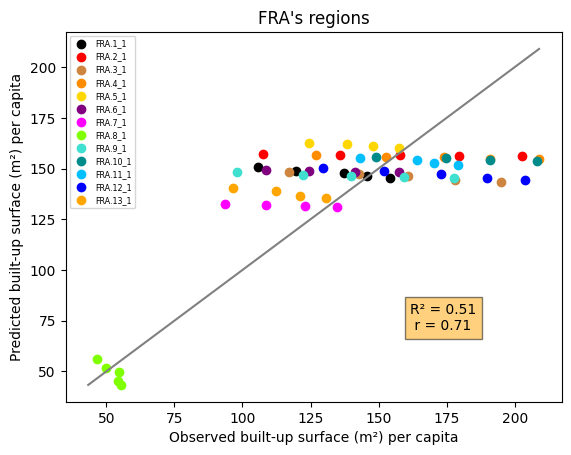

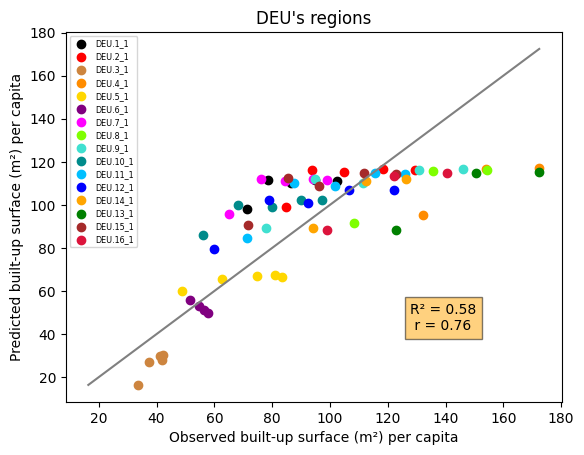

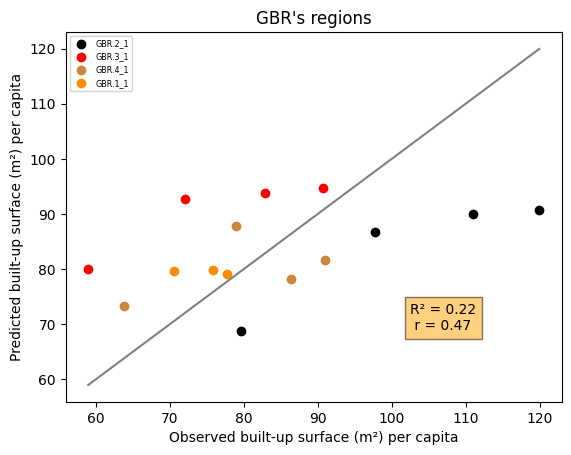

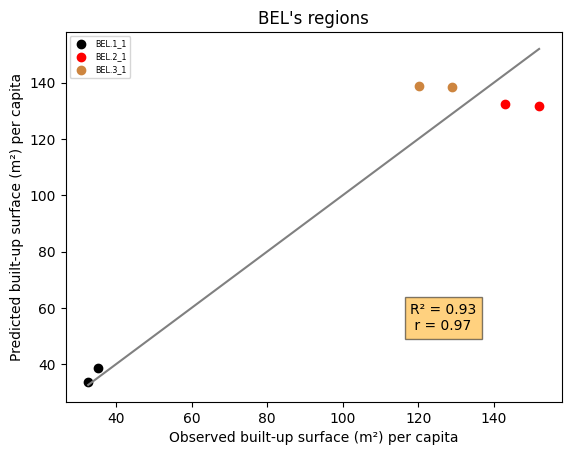

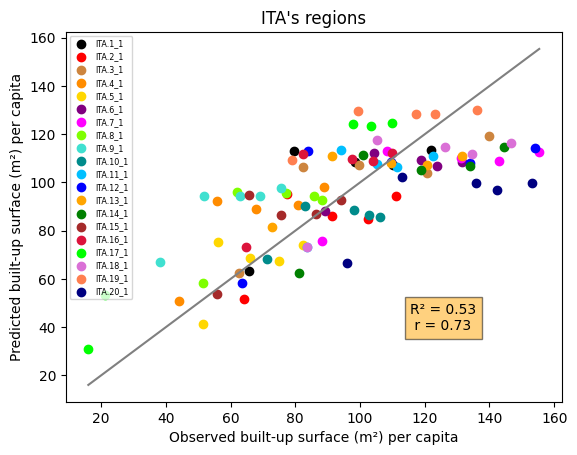

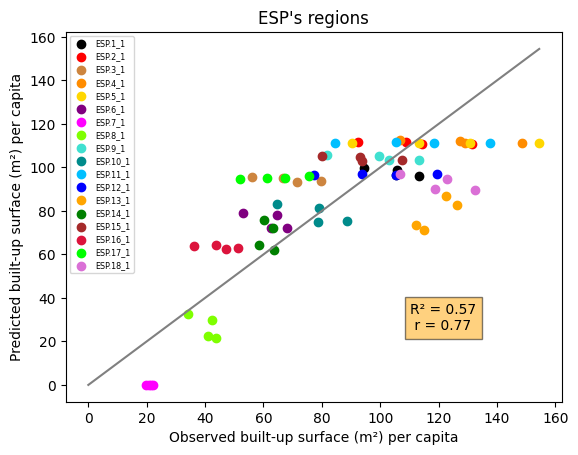

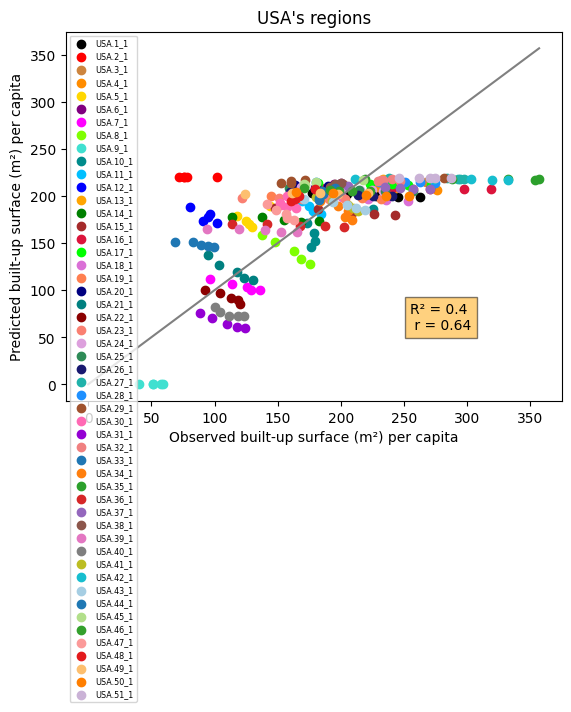

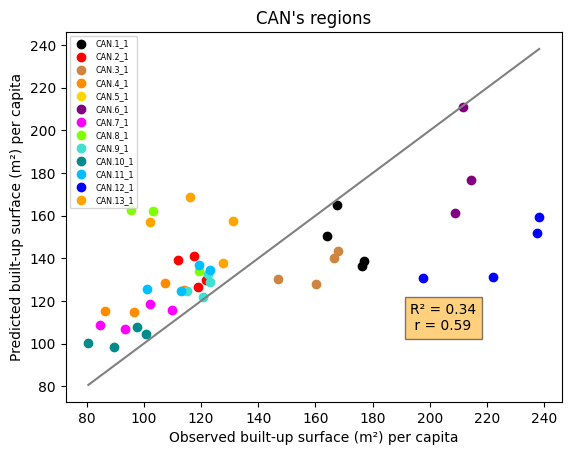

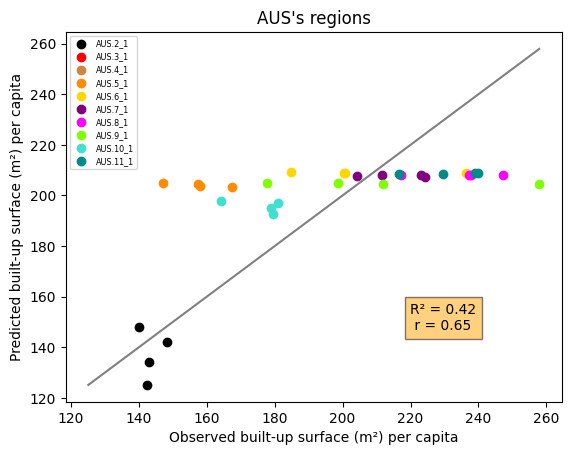

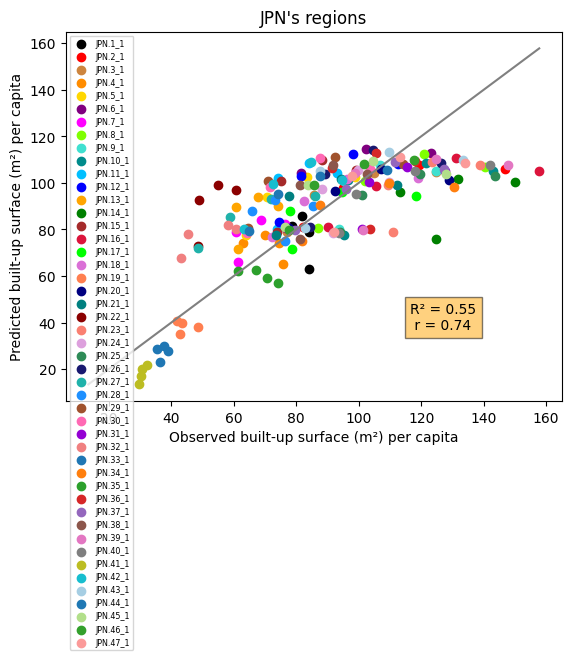

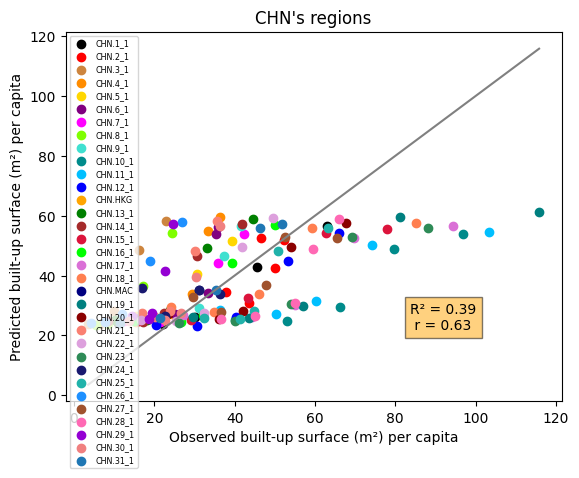

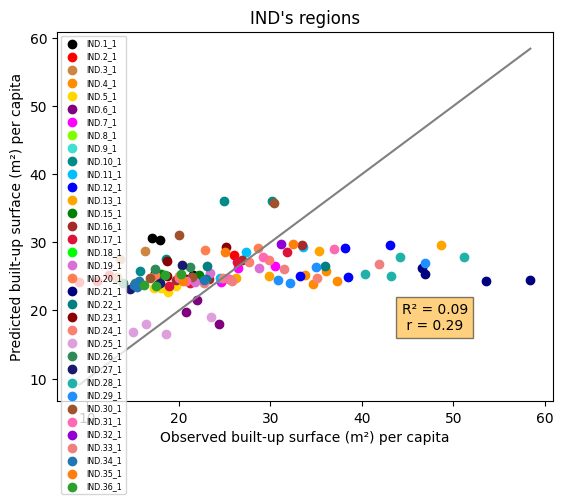

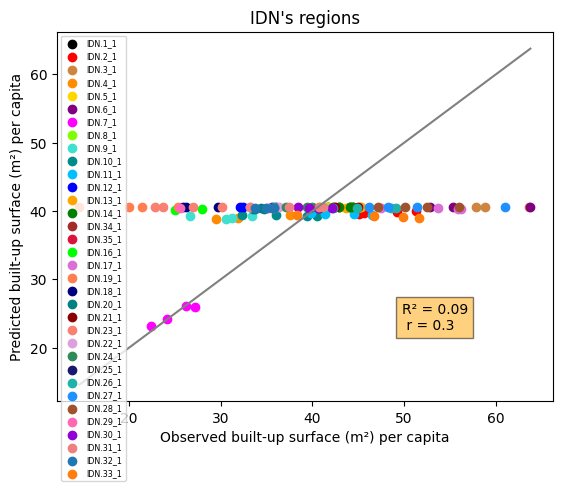

In [42]:
# here we plot the predicted values against the observations with the prediction fitted on the country. Every country has its own fit.

x1_col = "grp_pc_usd_2015"
x2_col = "Total surface"
y_col = "Built up surface GHSL"
pop_col = "pop"

reg_idx = -1
for region in regions:
    reg_idx += 1
    if use_automatic_fit:
        global_STL_fit_params = STL_fit_handler[reg_idx].fitted_params
    else:
        global_STL_fit_params = [saturation_fit_handler[reg_idx].fitted_params[0],saturation_fit_handler[reg_idx].fitted_params[1],logistic_fit_handler[reg_idx].fitted_params[1],logistic_fit_handler[reg_idx].fitted_params[2],]
    
    k = 0
    min_point = 999
    max_point = 0
    obs_region = []
    pred_region = []
    try:
        for subregion in region.subregions:
            
            filtered_df = subregion.output_df_merged.dropna(subset=[x1_col, x2_col, pop_col, y_col])
            x1 = filtered_df[x1_col]
            x2 = filtered_df[x2_col]
            y = filtered_df[y_col]
            pop =  filtered_df[pop_col]

            obs = y/pop
            pred = STL([x1,pop/x2], global_STL_fit_params[0], global_STL_fit_params[1], global_STL_fit_params[2], global_STL_fit_params[3]) 
            obs_region += obs.to_list()  
            pred_region += pred.to_list()
            plt.scatter(obs, pred, color=colors_reg[k % len(colors_reg)], label=subregion.name) #, alpha=(i+1)/6)

            try:
                min_point = min(min(min(obs), min(pred)), min_point)
                max_point = max(max(max(obs), max(pred)), max_point)
            except:
                pass
            
            k = k + 1
        
        
        x_plot_array = np.linspace(min_point, max_point, 50)
        plt.title(region.name + "'s regions")
        plt.plot(x_plot_array, x_plot_array, color='grey',)
        plt.text(x_plot_array[35], x_plot_array[8], "R² = "+str(round(R_SQ(np.array(obs_region), np.array(pred_region)),2))+"\n r = "+str(round(PEARSON(np.array(obs_region), np.array(pred_region))[0],2)), bbox=dict(facecolor="orange", alpha=0.5, edgecolor="black"))
        plt.ylabel("Predicted built-up surface (m²) per capita")
        plt.xlabel("Observed built-up surface (m²) per capita")
        plt.legend(loc="upper left", prop=fontP)
        plt.show()
    except Exception as e:
        print(region.name, "\n", e)

### PART 6.2 : with only one equation for every country

In [37]:
# Statistics with one equation for every region
best_region_fit = 0

if use_automatic_fit:
    global_STL_fit_params = STL_fit_handler[best_region_fit].fitted_params
else: 
    global_STL_fit_params = [saturation_fit_handler[best_region_fit].fitted_params[0], saturation_fit_handler[best_region_fit].fitted_params[1], logistic_fit_handler[best_region_fit].fitted_params[1], logistic_fit_handler[best_region_fit].fitted_params[2]]


for j in range(len(regions)):
    obs = df_built_up_region_handler[j]
    pred = STL([np.array(df_gdp_cap_region_handler[j]), np.array(df_pop_density_region_handler[j])], global_STL_fit_params[0], global_STL_fit_params[1], global_STL_fit_params[2], global_STL_fit_params[3])

    print(colored(regions[j].name+" with "+regions[best_region_fit].name+"'s fit.", "green"))
    print("RMSE: ", round(RMSE(obs, pred), 2))
    print("MAPE: ", round(MAPE(obs, pred), 2))
    print("STDR: ", round(STDR(obs, pred), 2))
    print("BIAS: ", round(BIAS(obs, pred), 2))
    print("R²  : ", round(R_SQ(obs, pred), 2))
    print("PEAR: ", round(PEARSON(obs, pred)[0], 2), " p_value: ", round(PEARSON(obs, pred)[1], 2))

FRA with FRA's fit.
RMSE:  27.97
MAPE:  16.78
STDR:  27.97
BIAS:  0.08
R²  :  0.51
PEAR:  0.71  p_value:  0.0
DEU with FRA's fit.
RMSE:  33.71
MAPE:  38.94
STDR:  33.19
BIAS:  -5.87
R²  :  -0.07
PEAR:  0.76  p_value:  0.0
GBR with FRA's fit.
RMSE:  57.57
MAPE:  68.4
STDR:  22.42
BIAS:  -53.02
R²  :  -12.03
PEAR:  0.18  p_value:  0.53
BEL with FRA's fit.
RMSE:  39.06
MAPE:  47.75
STDR:  25.0
BIAS:  30.02
R²  :  0.37
PEAR:  0.88  p_value:  0.02
ITA with FRA's fit.
RMSE:  45.23
MAPE:  53.42
STDR:  28.27
BIAS:  -35.31
R²  :  -1.35
PEAR:  0.48  p_value:  0.0
ESP with FRA's fit.
RMSE:  54.05
MAPE:  70.66
STDR:  27.24
BIAS:  -46.68
R²  :  -1.67
PEAR:  0.74  p_value:  0.0
USA with FRA's fit.
RMSE:  59.33
MAPE:  25.29
STDR:  49.51
BIAS:  32.7
R²  :  0.03
PEAR:  0.59  p_value:  0.0
CAN with FRA's fit.
RMSE:  53.02
MAPE:  41.89
STDR:  42.23
BIAS:  -32.06
R²  :  -0.51
PEAR:  0.55  p_value:  0.0
AUS with FRA's fit.
RMSE:  44.36
MAPE:  16.43
STDR:  29.58
BIAS:  33.07
R²  :  -0.62
PEAR:  0.64  p_valu

/tmp/ipykernel_169221/1988732562.py:6: RuntimeWarning: overflow encountered in exp
  return saturation / (1 + np.exp(-c*(x1-d)))
/tmp/ipykernel_169221/1988732562.py:6: RuntimeWarning: overflow encountered in exp
  return saturation / (1 + np.exp(-c*(x1-d)))
/tmp/ipykernel_169221/1988732562.py:6: RuntimeWarning: overflow encountered in exp
  return saturation / (1 + np.exp(-c*(x1-d)))
/tmp/ipykernel_169221/1988732562.py:6: RuntimeWarning: overflow encountered in exp
  return saturation / (1 + np.exp(-c*(x1-d)))


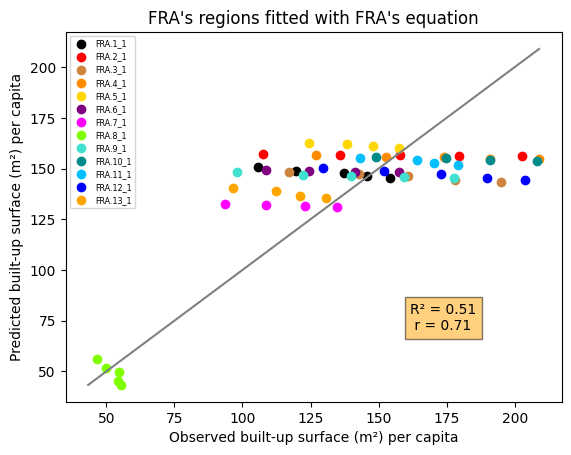

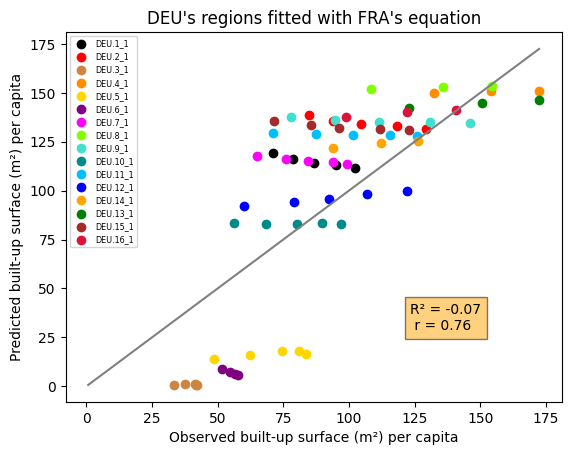

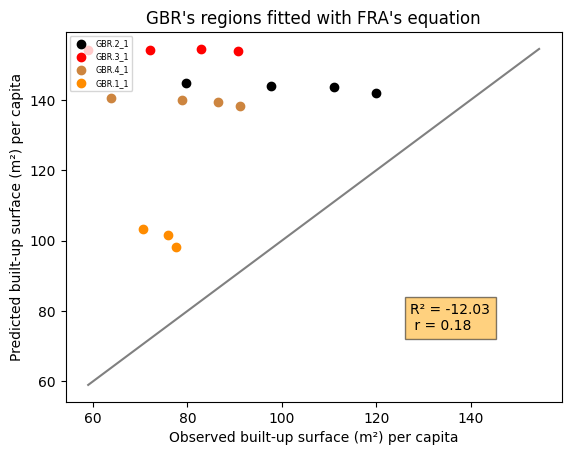

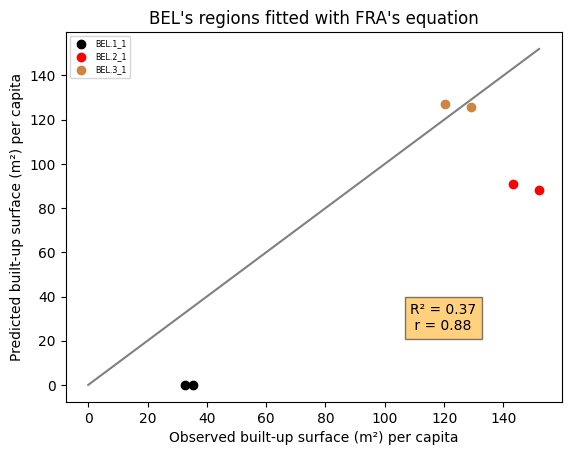

/home/hautervo/venv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


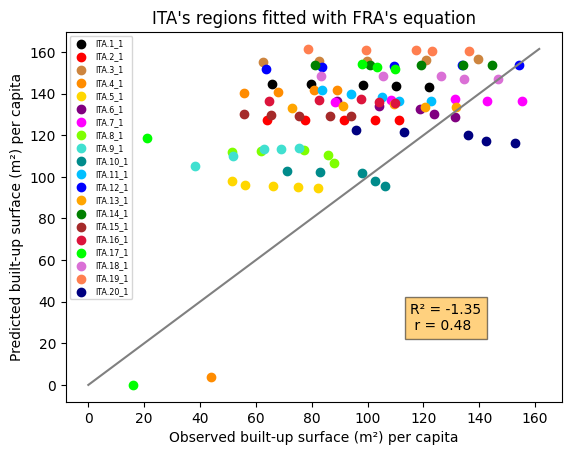

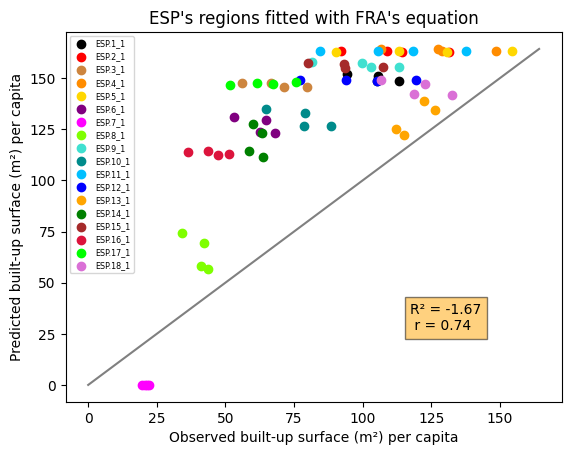

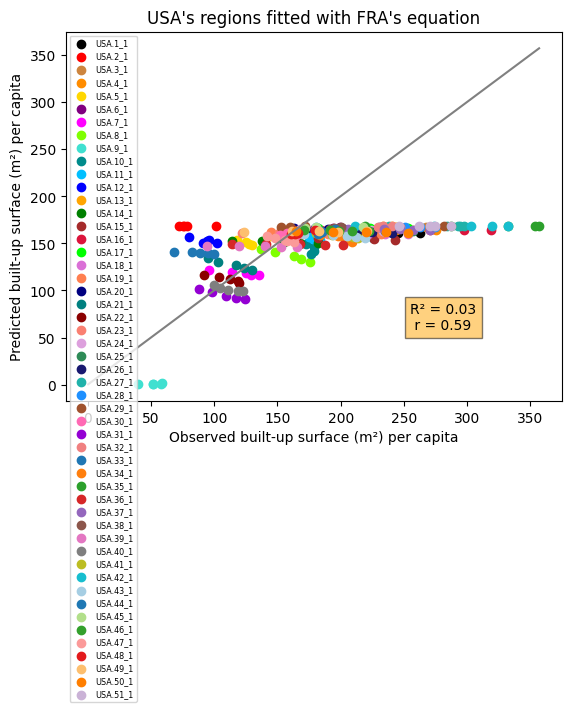

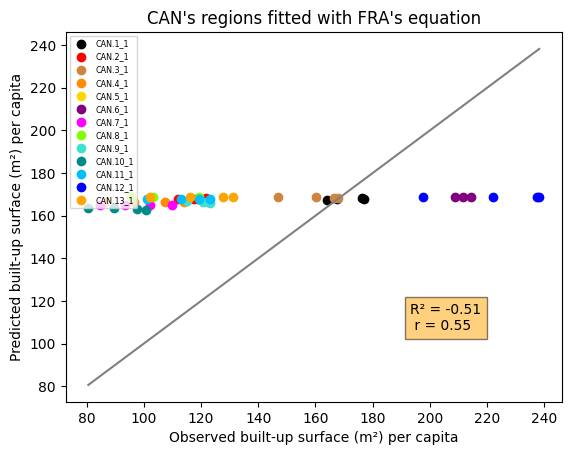

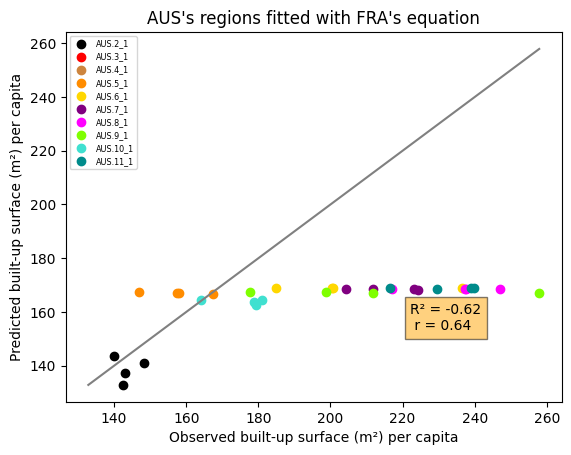

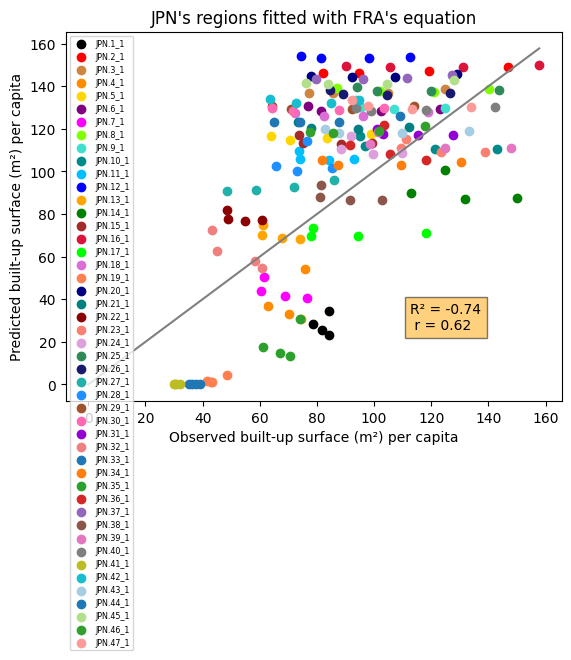

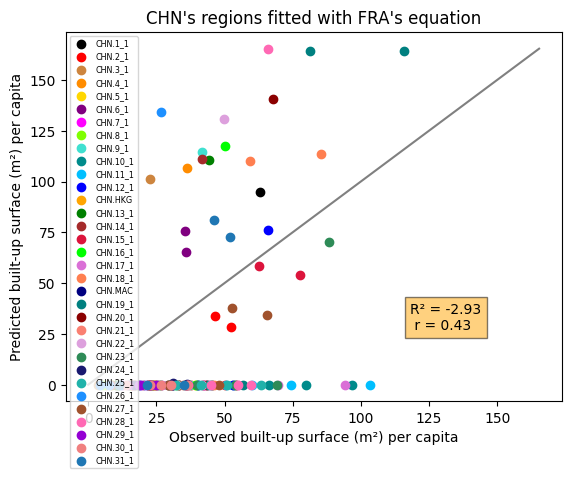

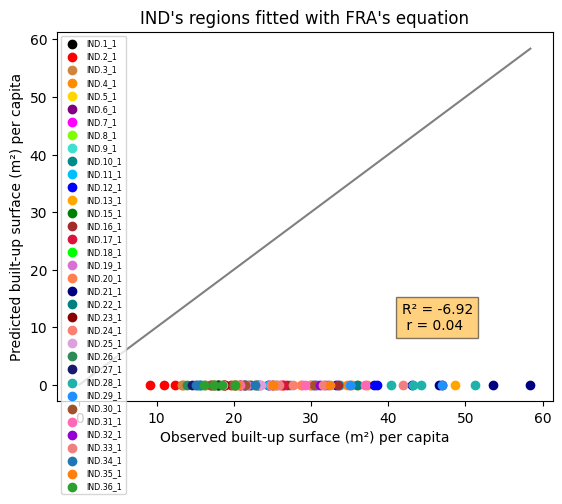

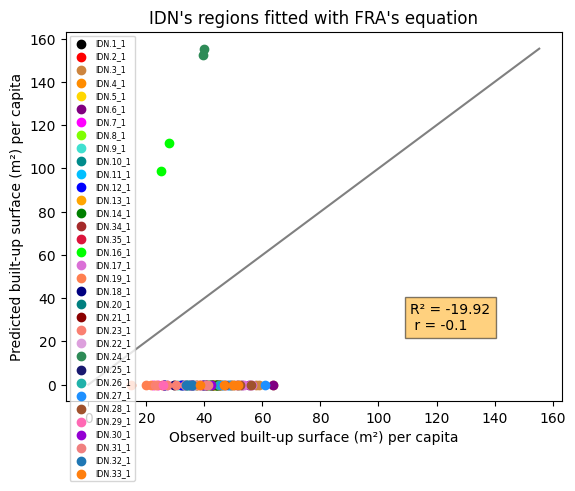

In [43]:
# here we compare all the predicted values with only one logistic curve. 

best_region_fit = 0

if use_automatic_fit:
    global_STL_fit_params = STL_fit_handler[best_region_fit].fitted_params
else: 
    global_STL_fit_params = [saturation_fit_handler[best_region_fit].fitted_params[0], saturation_fit_handler[best_region_fit].fitted_params[1], logistic_fit_handler[best_region_fit].fitted_params[1], logistic_fit_handler[best_region_fit].fitted_params[2]]

x1_col = "grp_pc_usd_2015"
x2_col = "Total surface"
y_col = "Built up surface GHSL"
pop_col = "pop"

for region in regions:
    k = 0
    min_point = 999
    max_point = 0
    obs_region = []
    pred_region = []
    try:
        for subregion in region.subregions:
            
            filtered_df = subregion.output_df_merged.dropna(subset=[x1_col, x2_col, pop_col, y_col])
            x1 = filtered_df[x1_col]
            x2 = filtered_df[x2_col]
            y = filtered_df[y_col]
            pop = filtered_df[pop_col]

            obs = y/pop
            pred = STL([x1, pop/x2], global_STL_fit_params[0], global_STL_fit_params[1], global_STL_fit_params[2], global_STL_fit_params[3])
            obs_region += obs.to_list()  
            pred_region += pred.to_list()
            
            plt.scatter(obs, pred, color=colors_reg[k % len(colors_reg)], label=subregion.name) #, alpha=(i+1)/6)

            try:
                min_point = min(min(min(obs), min(pred)), min_point)
                max_point = max(max(max(obs), max(pred)), max_point)
            except:
                pass
            
            k = k + 1
        
        x_plot_array = np.linspace(min_point, max_point, 50)
        plt.title(region.name + "'s regions fitted with " + regions[best_region_fit].name + "'s equation")
        plt.plot(x_plot_array, x_plot_array, color='grey',)
        plt.text(x_plot_array[35], x_plot_array[8], "R² = "+str(round(R_SQ(np.array(obs_region), np.array(pred_region)),2))+"\n r = "+str(round(PEARSON(np.array(obs_region), np.array(pred_region))[0],2)), bbox=dict(facecolor="orange", alpha=0.5, edgecolor="black"))
        plt.ylabel("Predicted built-up surface (m²) per capita")
        plt.xlabel("Observed built-up surface (m²) per capita")
        plt.legend(loc="upper left", prop=fontP)
        plt.show()
    except Exception as e:
        print(region.name, "\n", e)

### PART 6.3 Plot all on the same figure

In [39]:
# WORK IN PROGRESS

The End.